# Equity Spot-Futures Arbitrage: Implied Forward Rate Computation

This notebook demonstrates how to compute implied forward rates from equity index futures, mirroring the approach of Hazelkorn et al. (2021). Our goal is to construct:

$$
\text{ESF}_t \;=\; f_{t,\tau_1,\tau_2} \;-\; \text{OIS3M}_t
$$

where

$$
f_{t,\tau_1,\tau_2} \;=\; \frac{F_{t,\tau_2} + \mathbb{E}_t^Q[D_{t,\tau_2}]}{F_{t,\tau_1} + \mathbb{E}_t^Q[D_{t,\tau_1}]} - 1,
$$

and

$$
F_{t,\tau} \;=\; S_t\bigl(1 + r_{t,\tau}^f\bigr) \;-\; \mathbb{E}_t^Q[D_{t,\tau}].
$$

The difference between the **futures-implied forward rate** and the **3-month OIS rate** can reveal potential funding frictions or other market constraints that prevent perfect spot-futures arbitrage in equity markets.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar
import logging
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
sns.set_style('whitegrid')

# Add the src directory to the path to import our settings
sys.path.insert(1, "./src")
try:
    from settings import config
    print("Successfully imported config from settings module")
except ImportError:
    print("Failed to import config. Using local fallback.")
    def config(key):
        config_dict = {
            "DATA_DIR": Path("./_data"),
            "TEMP_DIR": Path("./_data/temp"),
            "INPUT_DIR": Path("./_data/input"),
            "PROCESSED_DIR": Path("./_data/processed"),
            "MANUAL_DATA_DIR": Path("./data_manual"),
            "OUTPUT_DIR": Path("./_output"),
            "START_DATE": "2010-01-01",
            "END_DATE": "2025-01-01"
        }
        return config_dict.get(key, Path("./data"))

# Basic paths
DATA_DIR = config("DATA_DIR")
TEMP_DIR = config("TEMP_DIR")
INPUT_DIR = config("INPUT_DIR")
PROCESSED_DIR = config("PROCESSED_DIR")
DATA_MANUAL = config("MANUAL_DATA_DIR")
OUTPUT_DIR = config("OUTPUT_DIR")

START_DATE = pd.to_datetime(config("START_DATE"))
END_DATE = pd.to_datetime(config("END_DATE"))

print(f"DATA_DIR = {DATA_DIR}")
print(f"PROCESSED_DIR = {PROCESSED_DIR}")
print(f"START_DATE = {START_DATE.date()}, END_DATE = {END_DATE.date()}")

INDEX_CODES = ["SPX", "NDX", "INDU"]

Successfully imported config from settings module
DATA_DIR = C:\Users\Andik\OneDrive\Desktop\Chicago\Full_stack_QF\Equity_Spot_futures_arb\_data
PROCESSED_DIR = C:\Users\Andik\OneDrive\Desktop\Chicago\Full_stack_QF\Equity_Spot_futures_arb\_data\processed
START_DATE = 2010-01-01, END_DATE = 2024-12-31


## Theoretical Background

In classical spot-futures parity for an equity index \(S_t\) that pays dividends from \(t\) to \(t + \tau\), the no-arbitrage futures price is:

$$
F_{t,\tau} \;=\; S_t\,(1 + r_{t,\tau}^f) \;-\; \mathbb{E}_t^Q[D_{t,\tau}].
$$

However, a direct spot vs. futures comparison can be noisy if they close at different times (e.g., 4:00 pm vs. 4:15 pm). Instead, we look at two futures contracts (maturing at \(\tau_1\) and \(\tau_2\)):

$$
1 + f_{t,\tau_1,\tau_2}
\;=\;
\frac{F_{t,\tau_2} + \mathbb{E}_t^Q[D_{t,\tau_2}]}{F_{t,\tau_1} + \mathbb{E}_t^Q[D_{t,\tau_1}]},
$$

to isolate the **implied forward rate** \(f_{t,\tau_1,\tau_2}\). We then define the **Equity Spot-Futures Arbitrage Spread** as:

$$
\text{ESF}_t \;=\; f_{t,\tau_1,\tau_2} \;-\; \text{OIS3M}_t.
$$

A positive \(\text{ESF}_t\) indicates the implied equity forward rate is higher than the OIS benchmark, potentially signaling a funding-cost wedge or other limits to arbitrage.


In [2]:
def build_daily_dividends(index_code: str) -> pd.DataFrame:
    """
    Load daily dividends for the given index code from bloomberg_historical_data.parquet.
    Return columns: [Date, Daily_Div].
    """
    print(f"[{index_code}] Building daily dividend table")

    input_file = Path(INPUT_DIR) / "bloomberg_historical_data.parquet"
    if not os.path.exists(input_file):
        print("Primary input file not found, switching to cached data")
        input_file = Path(DATA_MANUAL) / "bloomberg_historical_data.parquet"

    raw_df = pd.read_parquet(input_file)
    div_col = (f"{index_code} Index", "INDX_GROSS_DAILY_DIV")
    if div_col not in raw_df.columns:
        raise ValueError(f"Missing daily dividend column {div_col} for index={index_code}")

    div_df = raw_df.loc[:, div_col].to_frame("Daily_Div").reset_index()
    div_df.rename(columns={"index": "Date"}, inplace=True)
    div_df["Date"] = pd.to_datetime(div_df["Date"], errors="coerce")
    div_df["Daily_Div"] = div_df["Daily_Div"].fillna(0)

    # Optionally drop any row that has no valid date
    before_drop = len(div_df)
    div_df.dropna(subset=["Date"], inplace=True)
    after_drop = len(div_df)
    if after_drop < before_drop:
        print(f"[{index_code}] Dropped {before_drop - after_drop} rows with invalid or missing date in daily_div.")

    div_df.sort_values("Date", inplace=True)
    div_df.reset_index(drop=True, inplace=True)

    print(f"[{index_code}] daily dividends final shape: {div_df.shape}")
    print(f"[{index_code}] Sample daily dividends:\n{div_df.head(10)}")
    return div_df

In [3]:
def barndorff_nielsen_filter(df: pd.DataFrame,
                             colname: str,
                             date_col: str = "Date",
                             window: int = 45,
                             threshold: float = 10.0) -> pd.DataFrame:
    """
    Barndorff-Nielsen outlier filter on 'colname' over ±window days.
    1) rolling median => ...
    2) abs_dev from that median
    3) rolling mean(abs_dev) => mad
    4) outlier if abs_dev/mad >= threshold => set colname_filtered=NaN
    """
    df = df.sort_values(date_col).copy()

    rolling_median = df[colname].rolling(window=window*2+1, center=True, min_periods=1).median()
    rolling_median_shifted = rolling_median.shift(1)

    df["abs_dev"] = (df[colname] - rolling_median_shifted).abs()
    rolling_mad = df["abs_dev"].rolling(window=window*2+1, center=True, min_periods=1).mean()
    rolling_mad_shifted = rolling_mad.shift(1)

    df["bad_price"] = (df["abs_dev"] / rolling_mad_shifted) >= threshold
    df.loc[df[colname].isna(), "bad_price"] = False

    # Count how many outliers
    outlier_count = df["bad_price"].sum()
    if outlier_count > 0:
        print(f"Barndorff-Nielsen filter: flagged {int(outlier_count)} outliers in {colname}")

    df[f"{colname}_filtered"] = df[colname].where(~df["bad_price"], np.nan)

    df.drop(["abs_dev", "bad_price"], axis=1, inplace=True, errors="ignore")
    return df

In [4]:
def process_index_forward_rates(index_code: str) -> pd.DataFrame:
    """
    1) Load near/next futures for index_code from _Calendar_spread.csv
    2) Merge with single OIS_3M (as-of)
    3) Merge daily dividends, compute Div_Sum1_Comp & Div_Sum2_Comp
    4) Implied forward => cal_{index_code}_rf, OIS forward => ois_fwd_{index_code}, spread
    5) Barndorff outlier filter, then multiply spread by 100 => bps
    6) Return the DataFrame
    """
    print(f"[{index_code}] Starting forward rate computation")

    fut_file = Path(PROCESSED_DIR) / f"{index_code}_Calendar_spread.csv"
    if not fut_file.exists():
        print(f"[{index_code}] Missing futures file: {fut_file}")
        return pd.DataFrame()

    fut_df = pd.read_csv(fut_file)
    print(f"[{index_code}] Loaded futures shape: {fut_df.shape}")

    if "Date" not in fut_df.columns:
        print(f"[{index_code}] No 'Date' column in {fut_file}, aborting.")
        return pd.DataFrame()
    fut_df["Date"] = pd.to_datetime(fut_df["Date"], errors="coerce")

    before_drop = len(fut_df)
    fut_df.dropna(subset=["Date"], inplace=True)
    print(f"[{index_code}] Dropped {before_drop - len(fut_df)} rows lacking a valid Date in futures.")
    fut_df["Term1_SettlementDate"] = pd.to_datetime(fut_df["Term1_SettlementDate"], errors="coerce")
    fut_df["Term2_SettlementDate"] = pd.to_datetime(fut_df["Term2_SettlementDate"], errors="coerce")

    fut_df.sort_values("Date", inplace=True)
    fut_df.reset_index(drop=True, inplace=True)

    # === Merge single OIS_3M
    ois_file = Path(PROCESSED_DIR) / "cleaned_ois_rates.csv"
    if not ois_file.exists():
        print(f"[{index_code}] Missing OIS file: {ois_file}")
        return pd.DataFrame()

    ois_df = pd.read_csv(ois_file)
    if "Date" not in ois_df.columns:
        ois_df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    ois_df["Date"] = pd.to_datetime(ois_df["Date"], errors="coerce")
    ois_df.sort_values("Date", inplace=True)

    # as-of merge
    prev_len = len(fut_df)
    merged_df = pd.merge_asof(
        fut_df, ois_df, on="Date", direction="backward"
    )
    after_len = len(merged_df)
    print(f"[{index_code}] as-of merged OIS: from {prev_len} -> {after_len} rows (should be same).")

    # rename OIS_3M => 'OIS'
    if "OIS_3M" in merged_df.columns:
        merged_df.rename(columns={"OIS_3M": "OIS"}, inplace=True)
    else:
        print(f"[{index_code}] 'OIS_3M' column not found in OIS data, using default 'OIS_3M'?")

    # === Load daily dividends
    div_df = build_daily_dividends(index_code)
    # add cumsum in div_df
    div_df["CumDiv"] = div_df["Daily_Div"].cumsum()

    # merge cumsum at current date
    prev_len = len(merged_df)
    merged_df = pd.merge_asof(
        merged_df.sort_values("Date"),
        div_df[["Date", "CumDiv"]].sort_values("Date"),
        on="Date",
        direction="backward"
    )
    after_len = len(merged_df)
    print(
        f"[{index_code}] as-of merged CumDiv at current date: from {prev_len} -> {after_len} rows."
    )
    merged_df.rename(columns={"CumDiv": "CumDiv_current"}, inplace=True)
    print(f"[{index_code}] Sample merged rows with cumulative div:\n{merged_df.head(10)}")
    
    # same approach for Term1 & Term2
    t1_df = div_df.rename(columns={"Date": "Term1_SettlementDate", "CumDiv": "CumDiv_Term1"})
    prev_len = len(merged_df)
    merged_df = pd.merge_asof(
        merged_df.sort_values("Term1_SettlementDate"),
        t1_df.sort_values("Term1_SettlementDate"),
        on="Term1_SettlementDate",
        direction="backward"
    )
    after_len = len(merged_df)
    print(
        f"[{index_code}] as-of merged CumDiv for Term1: from {prev_len} -> {after_len} rows."
    )

    t2_df = div_df.rename(columns={"Date": "Term2_SettlementDate", "CumDiv": "CumDiv_Term2"})
    prev_len = len(merged_df)
    merged_df = pd.merge_asof(
        merged_df.sort_values("Term2_SettlementDate"),
        t2_df.sort_values("Term2_SettlementDate"),
        on="Term2_SettlementDate",
        direction="backward"
    )
    after_len = len(merged_df)
    print(
        f"[{index_code}] as-of merged CumDiv for Term2: from {prev_len} -> {after_len} rows."
    )

    # compute Div_Sum1 & Div_Sum2
    merged_df["Div_Sum1"] = merged_df["CumDiv_Term1"] - merged_df["CumDiv_current"]
    merged_df["Div_Sum2"] = merged_df["CumDiv_Term2"] - merged_df["CumDiv_current"]

    # Handle missing TTM or price
    # If TTM is missing, can't compute rates => drop
    before_drop = len(merged_df)
    merged_df.dropna(subset=["Term1_TTM", "Term2_TTM", "Term1_Futures_Price", "Term2_Futures_Price"], inplace=True)
    print(
        f"[{index_code}] Dropped {before_drop - len(merged_df)} rows missing TTM or Futures_Price."
    )

    # 4) Compounding
    ttm1 = "Term1_TTM"
    ttm2 = "Term2_TTM"
    merged_df["Div_Sum1_Comp"] = merged_df["Div_Sum1"] * (
        ((merged_df[ttm1] / 2.0) / 360.0) * merged_df["OIS"] + 1.0
    )
    merged_df["Div_Sum2_Comp"] = merged_df["Div_Sum2"] * (
        ((merged_df[ttm2] / 2.0) / 360.0) * merged_df["OIS"] + 1.0
    )

    # Implied Forward
    fp1 = "Term1_Futures_Price"
    fp2 = "Term2_Futures_Price"
    merged_df["implied_forward_raw"] = (
        (merged_df[fp2] + merged_df["Div_Sum2_Comp"]) /
        (merged_df[fp1] + merged_df["Div_Sum1_Comp"])
        - 1.0
    )

    dt = merged_df[ttm2] - merged_df[ttm1]
    merged_df[f"cal_{index_code}_rf"] = np.where(
        dt > 0,
        100.0 * merged_df["implied_forward_raw"] * (360.0 / dt),
        np.nan
    )

    # OIS-implied forward
    merged_df["ois_fwd_raw"] = (
        (1.0 + merged_df["OIS"] * merged_df[ttm2] / 360.0) /
        (1.0 + merged_df["OIS"] * merged_df[ttm1] / 360.0)
        - 1.0
    )
    merged_df[f"ois_fwd_{index_code}"] = np.where(
        dt > 0,
        merged_df["ois_fwd_raw"] * (360.0 / dt) * 100.0,
        np.nan
    )

    # Spread
    spread_col = f"spread_{index_code}"
    merged_df[spread_col] = merged_df[f"cal_{index_code}_rf"] - merged_df[f"ois_fwd_{index_code}"]
    
    # BN outlier filter
    merged_df = barndorff_nielsen_filter(merged_df, spread_col, date_col="Date", window=45, threshold=10)
    
    # If outlier => set cal_rf & spread to NaN
    out_mask = merged_df[f"{spread_col}_filtered"].isna()
    outliers_count = out_mask.sum()
    if outliers_count > 0:
        print(f"[{index_code}] Setting {outliers_count} outliers to NaN for cal_{index_code}_rf & {spread_col}")
    merged_df.loc[out_mask, f"cal_{index_code}_rf"] = np.nan
    merged_df.loc[out_mask, spread_col] = np.nan

    # Multiply spread by 100 => bps
    merged_df[spread_col] = merged_df[spread_col] * 100.0
    merged_df.set_index("Date", inplace=True)
    
    print(f"[{index_code}] Final forward rates shape: {merged_df.shape}")
    print(
        f"[{index_code}] Sample final rows:\n"
        + merged_df[[f"cal_{index_code}_rf", f"ois_fwd_{index_code}", spread_col]].tail(5).to_string()
    )

    return merged_df

In [5]:
def plot_all_indices(results: dict, keep_dates: bool = True):
    """
    Generate two charts for each index's final spread_{idx} in basis points:
    1. From START_DATE to 2020-01-01
    2. From START_DATE to END_DATE (full range)
    
    By default (keep_dates=True), we reindex to the union of all dates to keep the
    X-axis from skipping days that are missing in some index.
    
    If you want to only show existing dates in each index's data, set keep_dates=False.
    """
    # Define date ranges
    pre_2020_end = pd.to_datetime('2020-01-01')
    
    # If keep_dates: find the union of all dates across all DataFrames
    if keep_dates:
        all_dates = set()
        for idx, df in results.items():
            if df is not None and not df.empty:
                all_dates.update(df.index.tolist())
        # Build a sorted list
        date_index = pd.to_datetime(sorted(all_dates))
    else:
        date_index = None

    colors = {"SPX": "blue", "NDX": "green", "INDU": "red"}
    
    # Create Figure 1: START_DATE to 2020-01-01
    plt.figure(figsize=(12, 7))
    for idx, df in results.items():
        if df is not None and not df.empty:
            spread_col = f"spread_{idx}"
            # Filter to pre-2020 data
            pre_2020_df = df[df.index <= pre_2020_end]
            
            # If empty after filtering, skip
            if pre_2020_df.empty:
                continue
                
            # reindex if desired
            if keep_dates and date_index is not None:
                filtered_dates = date_index[date_index <= pre_2020_end]
                df_plot = pre_2020_df.reindex(filtered_dates).ffill()  # Forward fill missing values
            else:
                df_plot = pre_2020_df
                
            plt.plot(
                df_plot.index,
                df_plot[spread_col],
                color=colors.get(idx, "black"),
                alpha=0.8,
                label=f"{idx} Spread (bps)"
            )

    plt.axhline(0, color="k", linestyle="--", alpha=0.7)
    plt.title("Implied Forward Spread Across Indices (Pre-2020, bps)")
    plt.xlabel("Date")
    plt.ylabel("Spread (bps)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
    
    # Display the first plot
    plt.show()
    
    # Create Figure 2: START_DATE to END_DATE (full range)
    plt.figure(figsize=(12, 7))
    for idx, df in results.items():
        if df is not None and not df.empty:
            spread_col = f"spread_{idx}"
            # reindex if desired
            if keep_dates and date_index is not None:
                df_plot = df.reindex(date_index).ffill()  # Forward fill missing values
            else:
                df_plot = df
                
            plt.plot(
                df_plot.index,
                df_plot[spread_col],
                color=colors.get(idx, "black"),
                alpha=0.8,
                label=f"{idx} Spread (bps)"
            )

    plt.axhline(0, color="k", linestyle="--", alpha=0.7)
    plt.title("Implied Forward Spread Across Indices (Full Range, bps)")
    plt.xlabel("Date")
    plt.ylabel("Spread (bps)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
    
    # Display the second plot
    plt.show()

== Starting forward rate calculations with compounding dividends, single OIS, BN outlier filter ==
[SPX] Starting forward rate computation
[SPX] Loaded futures shape: (3781, 14)
[SPX] Dropped 0 rows lacking a valid Date in futures.
[SPX] as-of merged OIS: from 3781 -> 3781 rows (should be same).
[SPX] Building daily dividend table
Primary input file not found, switching to cached data
[SPX] daily dividends final shape: (3913, 2)
[SPX] Sample daily dividends:
        Date  Daily_Div
0 2010-01-01   0.000000
1 2010-01-04   0.058362
2 2010-01-05   0.001744
3 2010-01-06   0.497980
4 2010-01-07   0.061819
5 2010-01-08   0.000000
6 2010-01-11   0.000000
7 2010-01-12   0.000000
8 2010-01-13   0.113508
9 2010-01-14   0.021957
[SPX] as-of merged CumDiv at current date: from 3781 -> 3781 rows.
[SPX] Sample merged rows with cumulative div:
        Date  Term1_Futures_Price  Term1_Volume  Term1_OpenInterest  \
0 2010-01-04              1128.75     1282633.0           2440458.0   
1 2010-01-05      

[SPX] as-of merged CumDiv for Term1: from 3781 -> 3781 rows.
[SPX] as-of merged CumDiv for Term2: from 3781 -> 3781 rows.
[SPX] Dropped 0 rows missing TTM or Futures_Price.
Barndorff-Nielsen filter: flagged 47 outliers in spread_SPX
[SPX] Setting 47 outliers to NaN for cal_SPX_rf & spread_SPX
[SPX] Final forward rates shape: (3781, 29)
[SPX] Sample final rows:
            cal_SPX_rf  ois_fwd_SPX  spread_SPX
Date                                           
2024-12-24    3.778583     4.287412  -50.882869
2024-12-26    3.796641     4.277498  -48.085749
2024-12-27    3.741256     4.277624  -53.636841
2024-12-30    3.717731     4.275913  -55.818186
2024-12-31    3.698950     4.274017  -57.506667
[NDX] Starting forward rate computation
[NDX] Loaded futures shape: (3781, 14)
[NDX] Dropped 0 rows lacking a valid Date in futures.
[NDX] as-of merged OIS: from 3781 -> 3781 rows (should be same).
[NDX] Building daily dividend table
Primary input file not found, switching to cached data
[NDX] daily 

Barndorff-Nielsen filter: flagged 48 outliers in spread_NDX
[NDX] Setting 48 outliers to NaN for cal_NDX_rf & spread_NDX
[NDX] Final forward rates shape: (3781, 29)
[NDX] Sample final rows:
            cal_NDX_rf  ois_fwd_NDX  spread_NDX
Date                                           
2024-12-24    4.341428     4.287412    5.401572
2024-12-26    4.426357     4.277498   14.885916
2024-12-27    4.384662     4.277624   10.703781
2024-12-30    4.322400     4.275913    4.648708
2024-12-31    4.323851     4.274017    4.983391
[INDU] Starting forward rate computation
[INDU] Loaded futures shape: (3780, 14)
[INDU] Dropped 0 rows lacking a valid Date in futures.
[INDU] as-of merged OIS: from 3780 -> 3780 rows (should be same).
[INDU] Building daily dividend table
Primary input file not found, switching to cached data
[INDU] daily dividends final shape: (3913, 2)
[INDU] Sample daily dividends:
        Date  Daily_Div
0 2010-01-01   0.000000
1 2010-01-04   0.377875
2 2010-01-05   0.000000
3 2010-

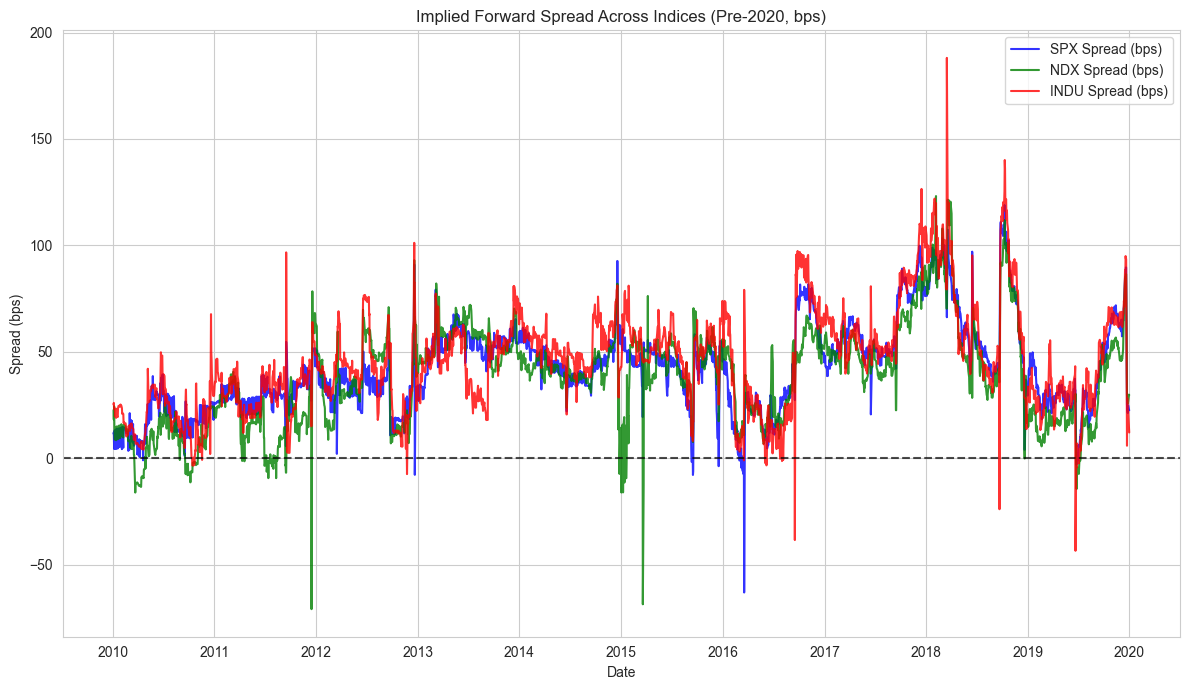

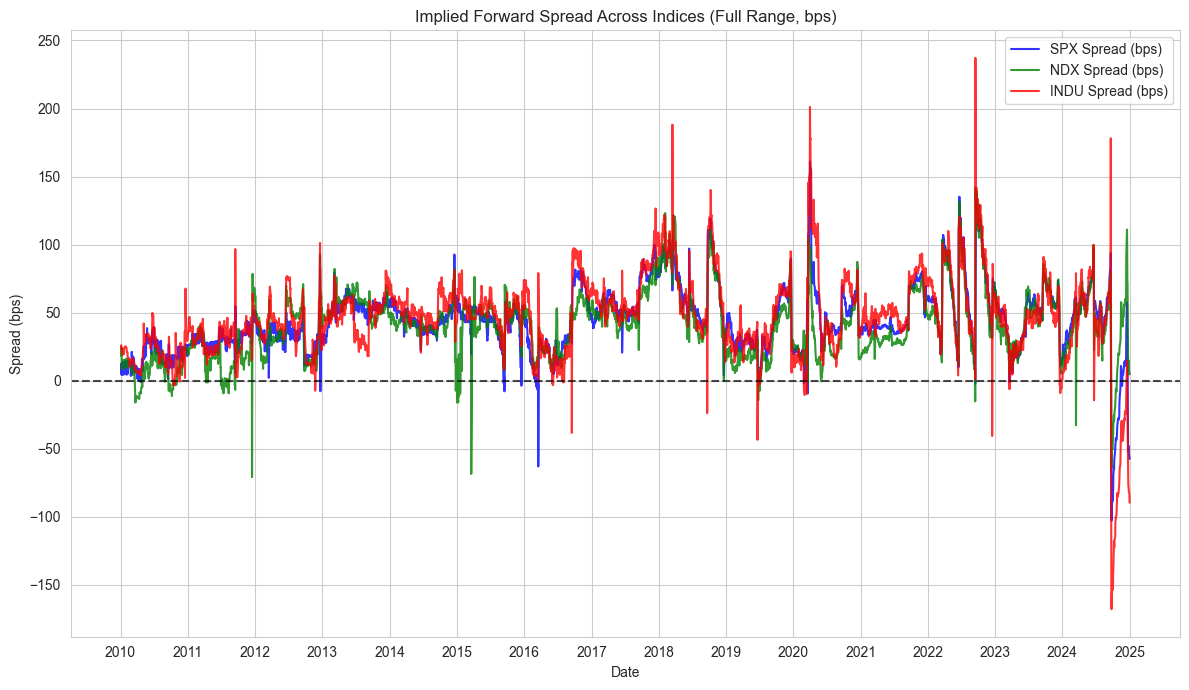

All computations completed successfully.


In [6]:
def main():
    print("== Starting forward rate calculations with compounding dividends, single OIS, BN outlier filter ==")
    results = {}
    for idx in INDEX_CODES:
        df_res = process_index_forward_rates(idx)
        results[idx] = df_res
    
    # Create both plots
    plot_all_indices(results, keep_dates=True)

    print("All computations completed successfully.")

# Execute the main function
if __name__ == "__main__":
    main()

# Exploring the Functions: Visual Understanding of Implied Forward Rate Calculation

This notebook provides a step-by-step exploration of each function in the implied forward rate calculation process, with visualizations and tables to help build intuition about what's happening at each stage.

1. Data loading and preprocessing
2. Daily dividend accumulation
3. Barndorff-Nielsen outlier filtering mechanism
4. The forward rate calculation process
5. Visualization of results

Let's break down each component visually to understand the theory.

=== Exploring build_daily_dividends for SPX ===

Raw Bloomberg data structure:
Shape: (3913, 62)
Column structure (MultiIndex):
MultiIndex([( 'SPX Index',              'PX_LAST'),
            ( 'SPX Index',      'IDX_EST_DVD_YLD'),
            ( 'SPX Index', 'INDX_GROSS_DAILY_DIV'),
            ( 'NDX Index',              'PX_LAST'),
            ( 'NDX Index',      'IDX_EST_DVD_YLD'),
            ( 'NDX Index', 'INDX_GROSS_DAILY_DIV'),
            ('INDU Index',              'PX_LAST'),
            ('INDU Index',      'IDX_EST_DVD_YLD'),
            ('INDU Index', 'INDX_GROSS_DAILY_DIV'),
            ( 'ES1 Index',              'PX_LAST')],
           )

Processed dividend data (first 5 rows):


,Date,Daily_Div,CumDiv
0,2010-01-01,0.000000,0.000000
1,2010-01-04,0.058362,0.058362
2,2010-01-05,0.001744,0.060106
3,2010-01-06,0.497980,0.558086
4,2010-01-07,0.061819,0.619905


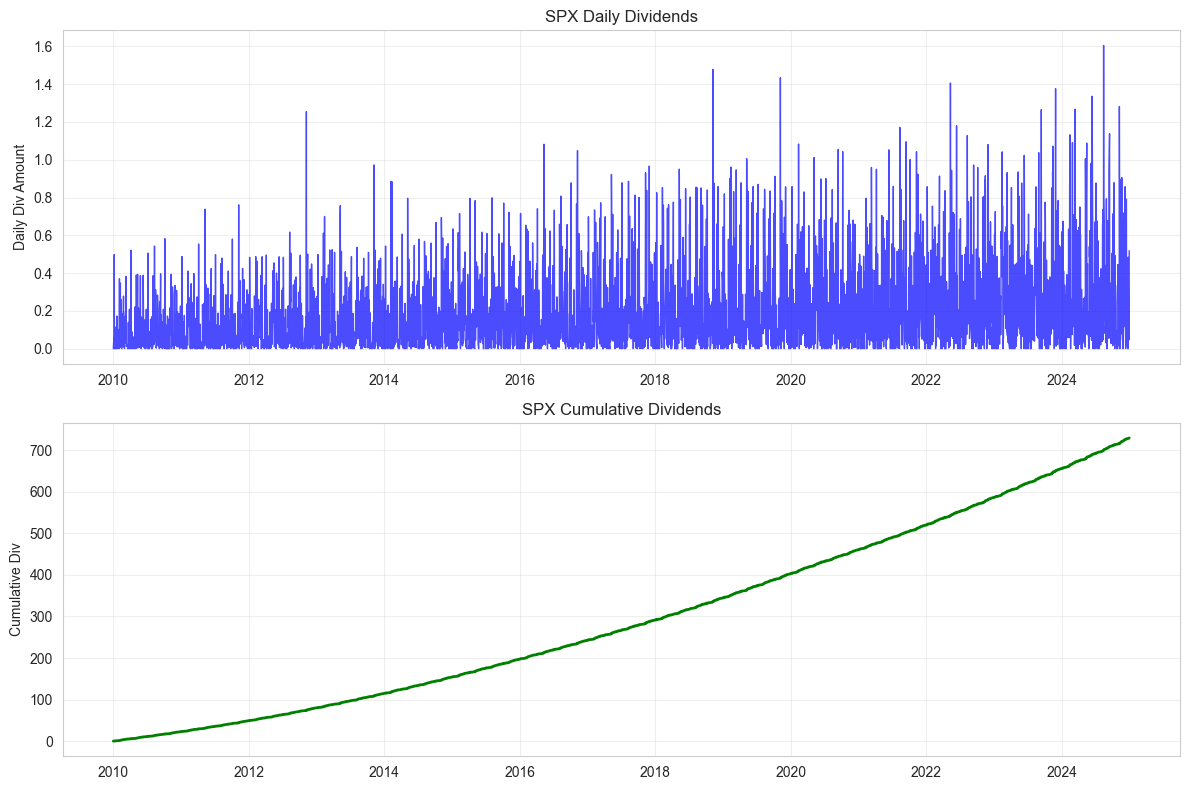


Dividend Data Summary:


count    3913.000000
mean        0.186435
std         0.228265
min         0.000000
25%         0.022825
50%         0.095385
75%         0.271259
max         1.604820
Name: Daily_Div, dtype: float64

Days with zero dividends: 447 (11.4% of total)
Days with non-zero dividends: 3466 (88.6% of total)


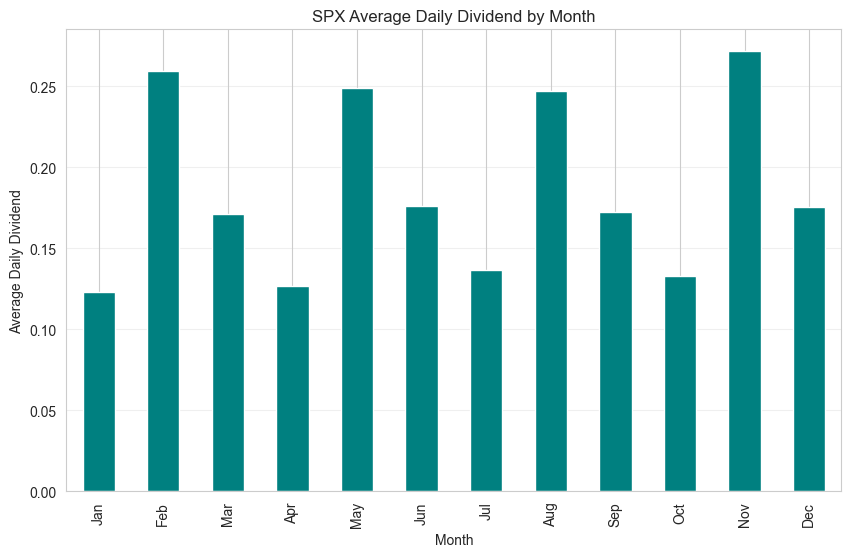

In [7]:
# Function to visualize and explain daily dividends
def explore_daily_dividends(index_code="SPX"):
    """
    Explore and visualize how the daily dividend function works
    """
    print(f"=== Exploring build_daily_dividends for {index_code} ===")
    
    # Load the data
    input_file = Path(INPUT_DIR) / "bloomberg_historical_data.parquet"
    if not input_file.exists():
        input_file = Path(DATA_MANUAL) / "bloomberg_historical_data.parquet"
        
    if not input_file.exists():
        print("No Bloomberg data file found. Cannot proceed with exploration.")
        return None
    
    # Load raw data
    raw_df = pd.read_parquet(input_file)
    
    # Show the structure of the raw dataframe
    print("\nRaw Bloomberg data structure:")
    print(f"Shape: {raw_df.shape}")
    print("Column structure (MultiIndex):")
    print(raw_df.columns[:10])  # Show first 10 columns
    
    # Extract dividend column
    div_col = (f"{index_code} Index", "INDX_GROSS_DAILY_DIV")
    if div_col not in raw_df.columns:
        print(f"Missing dividend column for {index_code}. Trying a different approach...")
        # Try to find any dividend-related columns
        div_cols = [col for col in raw_df.columns if 'DIV' in str(col)]
        if div_cols:
            print(f"Found potential dividend columns: {div_cols}")
            div_col = div_cols[0]
        else:
            print("No dividend columns found in the data.")
            return None
    
    # Process dividends as in the original function
    div_df = raw_df.loc[:, div_col].to_frame("Daily_Div").reset_index()
    div_df.rename(columns={"index": "Date"}, inplace=True)
    div_df["Date"] = pd.to_datetime(div_df["Date"], errors="coerce")
    div_df["Daily_Div"] = div_df["Daily_Div"].fillna(0)
    div_df.dropna(subset=["Date"], inplace=True)
    div_df.sort_values("Date", inplace=True)
    div_df.reset_index(drop=True, inplace=True)
    
    # Create cumulative sum column
    div_df["CumDiv"] = div_df["Daily_Div"].cumsum()
    
    # Display processed data
    print("\nProcessed dividend data (first 5 rows):")
    display(div_df.head())
    
    # Visualize daily dividends
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Daily dividends over time
    plt.subplot(2, 1, 1)
    plt.plot(div_df["Date"], div_df["Daily_Div"], 'b-', alpha=0.7, linewidth=1)
    plt.title(f"{index_code} Daily Dividends")
    plt.ylabel("Daily Div Amount")
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Cumulative dividends
    plt.subplot(2, 1, 2)
    plt.plot(div_df["Date"], div_df["CumDiv"], 'g-', linewidth=2)
    plt.title(f"{index_code} Cumulative Dividends")
    plt.ylabel("Cumulative Div")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nDividend Data Summary:")
    summary = div_df["Daily_Div"].describe()
    display(summary)
    
    # Show time periods with zero and non-zero dividends
    zero_div = div_df[div_df["Daily_Div"] == 0].shape[0]
    total = div_df.shape[0]
    print(f"Days with zero dividends: {zero_div} ({zero_div/total:.1%} of total)")
    print(f"Days with non-zero dividends: {total - zero_div} ({(total-zero_div)/total:.1%} of total)")
    
    # Monthly dividend patterns (Useful to see if there are dividend seasons)
    div_df['month'] = div_df['Date'].dt.month
    div_df['year'] = div_df['Date'].dt.year
    
    monthly_pattern = div_df.groupby('month')['Daily_Div'].mean()
    
    plt.figure(figsize=(10, 6))
    monthly_pattern.plot(kind='bar', color='teal')
    plt.title(f"{index_code} Average Daily Dividend by Month")
    plt.xlabel("Month")
    plt.ylabel("Average Daily Dividend")
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()
    
    return div_df

# Run the exploration
spx_div_df = explore_daily_dividends("SPX")

## Understanding Daily Dividends

The `build_daily_dividends()` function extracts daily dividend information from the Bloomberg data and prepares it for use in the forward rate calculations.

Key observations:
1. The function extracts a specific column from a multi-index DataFrame
2. It converts dates, fills missing values with zeros, and sorts by date
3. Daily dividends are typically sparse - many days have zero dividends
4. The cumulative dividend is critical for the forward rate calculation
5. There may be seasonal patterns in dividend payments

The visualizations show both the daily dividend amounts (which are typically spiky) and the cumulative dividends (which grow over time). The monthly pattern chart helps identify any seasonality in dividend payments.

These dividend values will be used in the `Div_Sum1` and `Div_Sum2` calculations, which represent the expected dividends between the current date and the settlement dates.

=== Exploring Barndorff-Nielsen Filter ===


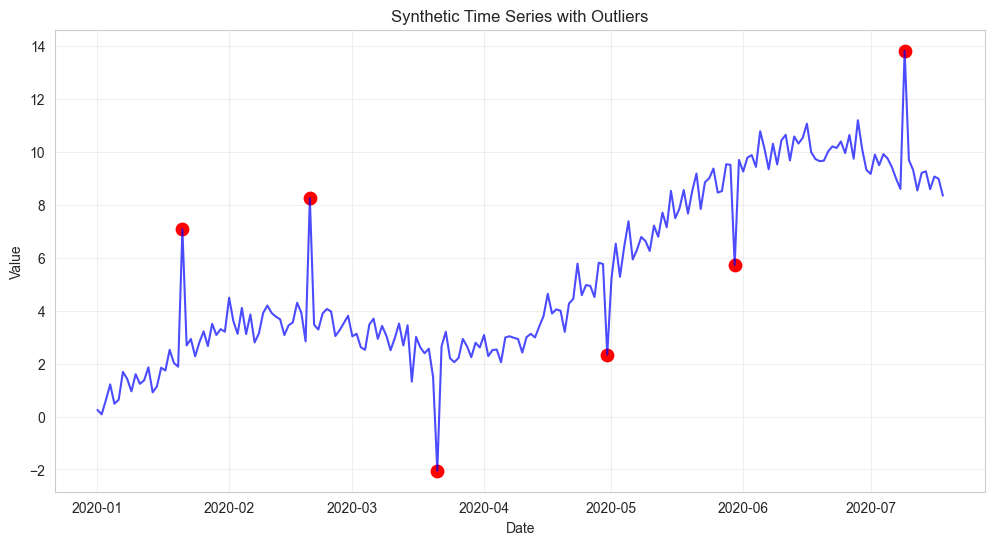


Step-by-step filter process (showing sample rows):


,Date,value,abs_dev,std_dev,is_outlier,value_filtered
15,2020-01-16,1.841408,0.103501,0.197860,False,1.841408
16,2020-01-17,1.737907,0.103501,0.203625,False,1.737907
17,2020-01-18,2.519580,0.661327,1.311529,False,2.519580
18,2020-01-19,2.022771,0.141783,0.284550,False,2.022771
19,2020-01-20,1.880988,0.141783,0.289496,False,1.880988
20,2020-01-21,7.071302,4.797679,9.889070,True,NaN
21,2020-01-22,2.682461,0.162881,0.345661,False,2.682461
22,2020-01-23,2.926694,0.265088,0.501126,False,2.926694
23,2020-01-24,2.273623,0.408838,0.746192,False,2.273623
24,2020-01-25,2.802253,0.000000,0.000000,False,2.802253


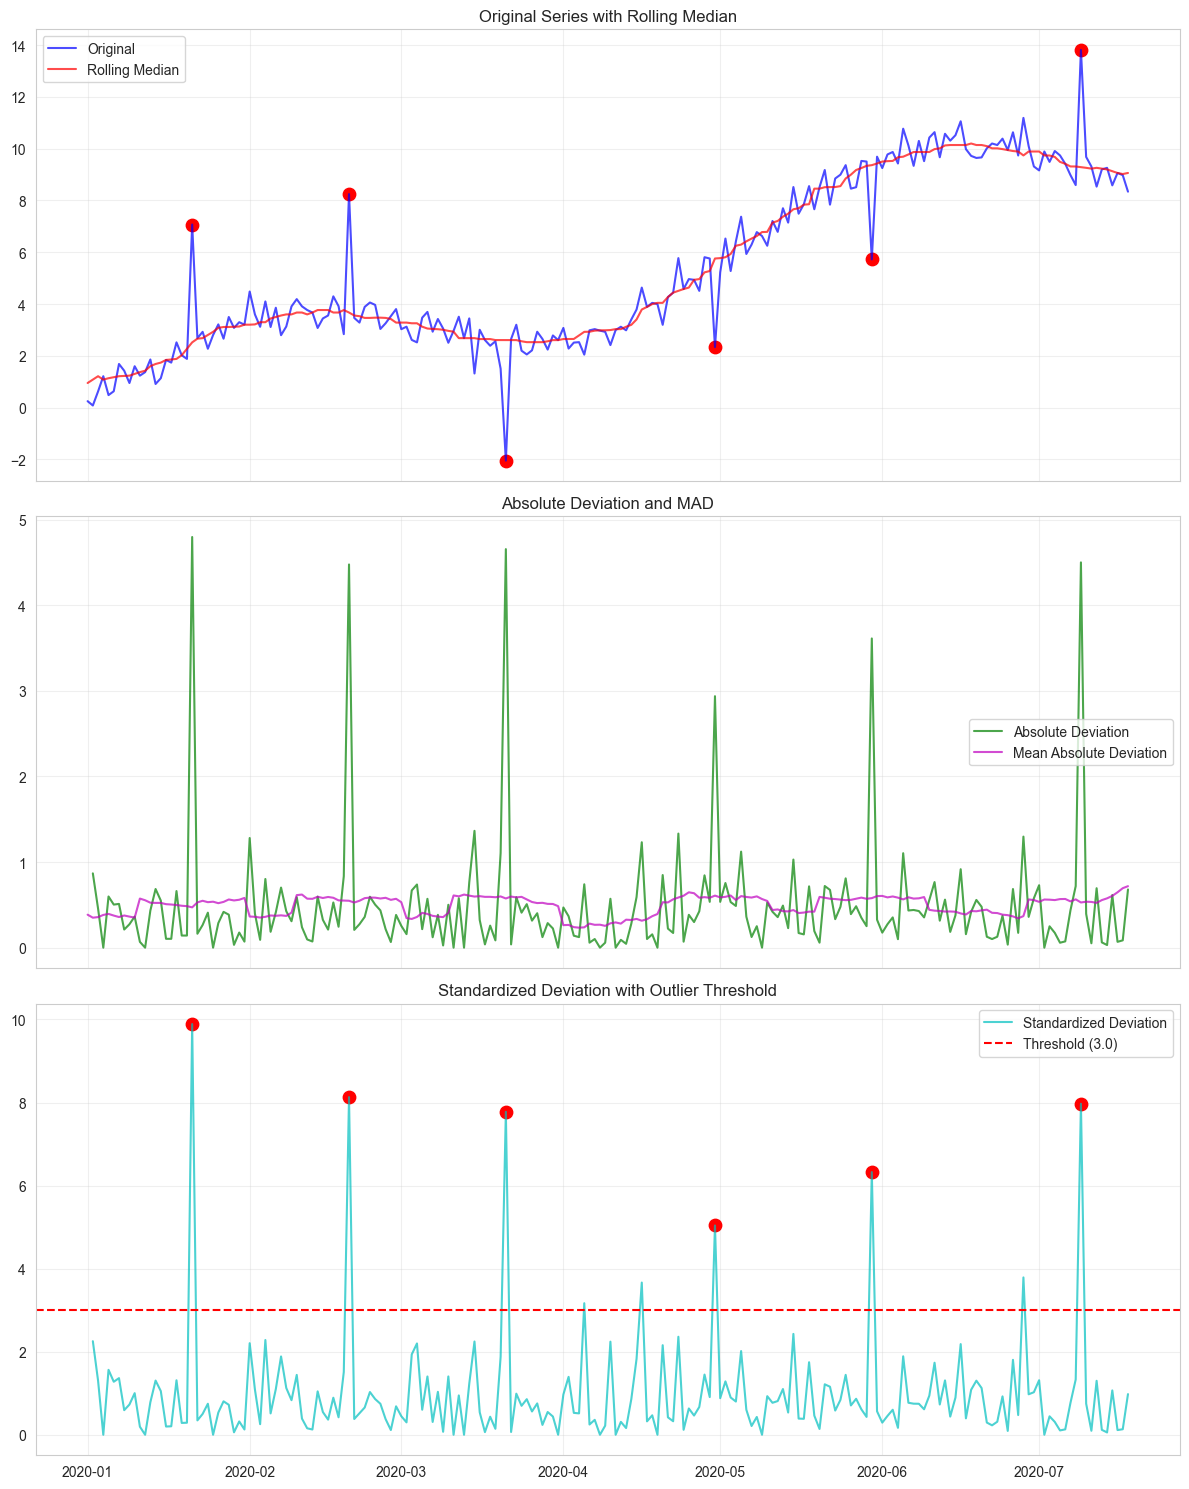

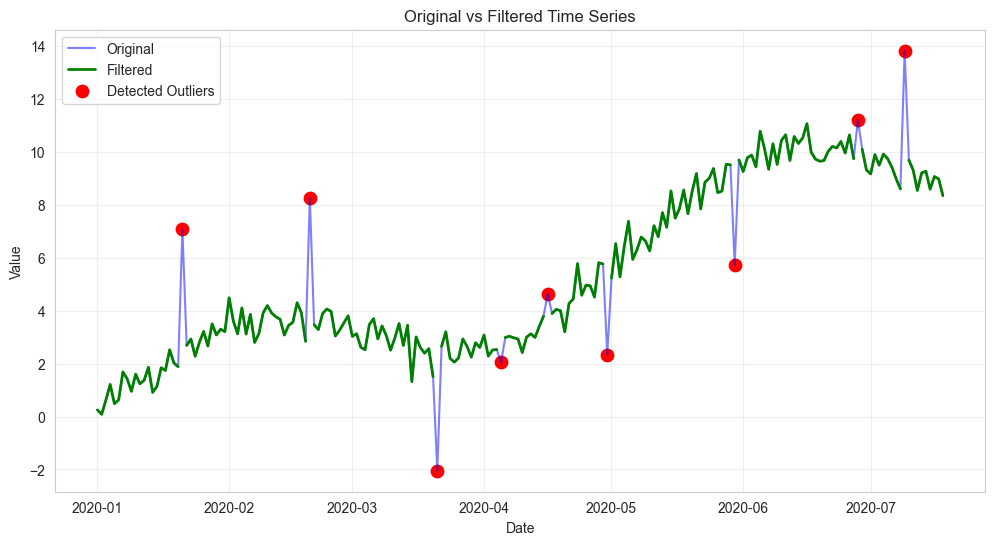


Summary: Detected 9 outliers out of 200 observations
True outliers detected: 6 out of 6
Detection rate: 100.0%


In [8]:
def explore_barndorff_nielsen_filter():
    """
    Demonstrate how the Barndorff-Nielsen outlier filter works with a synthetic dataset
    """
    print("=== Exploring Barndorff-Nielsen Filter ===")
    
    # Create a synthetic time series with some outliers
    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', periods=200)
    
    # Base series with some seasonality and trend
    base = np.linspace(0, 10, 200) + 2 * np.sin(np.linspace(0, 10, 200))
    
    # Add noise
    noise = np.random.normal(0, 0.5, 200)
    
    # Add outliers
    outliers_idx = [20, 50, 80, 120, 150, 190]
    outliers = np.zeros(200)
    for idx in outliers_idx:
        outliers[idx] = np.random.choice([-1, 1]) * np.random.uniform(3, 5)
    
    # Combined series
    values = base + noise + outliers
    
    # Create DataFrame
    df = pd.DataFrame({
        'Date': dates,
        'value': values
    })
    
    # Visualize the original series
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['value'], 'b-', alpha=0.7)
    for idx in outliers_idx:
        plt.scatter(df['Date'][idx], df['value'][idx], color='red', s=80)
    plt.title('Synthetic Time Series with Outliers')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Apply the Barndorff-Nielsen filter
    window = 10  # Smaller window for demonstration
    threshold = 3.0  # Lower threshold to catch all our synthetic outliers
    
    # Sort the data
    df = df.sort_values('Date')
    
    # Calculate rolling median
    rolling_median = df['value'].rolling(window=window*2+1, center=True, min_periods=1).median()
    rolling_median_shifted = rolling_median.shift(1)
    
    # Calculate absolute deviation
    df['abs_dev'] = (df['value'] - rolling_median_shifted).abs()
    
    # Calculate rolling MAD (Mean Absolute Deviation)
    rolling_mad = df['abs_dev'].rolling(window=window*2+1, center=True, min_periods=1).mean()
    rolling_mad_shifted = rolling_mad.shift(1)
    
    # Calculate standardized deviation
    df['std_dev'] = df['abs_dev'] / rolling_mad_shifted
    
    # Determine outliers
    df['is_outlier'] = df['std_dev'] >= threshold
    df.loc[df['value'].isna(), 'is_outlier'] = False
    
    # Create filtered series
    df['value_filtered'] = df['value'].where(~df['is_outlier'], np.nan)
    
    # Show step-by-step calculations for better understanding
    print("\nStep-by-step filter process (showing sample rows):")
    display(df[['Date', 'value', 'abs_dev', 'std_dev', 'is_outlier', 'value_filtered']].iloc[15:25])
    
    # Visualize the filtering steps
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    # Original with rolling median
    axes[0].plot(df['Date'], df['value'], 'b-', alpha=0.7, label='Original')
    axes[0].plot(df['Date'], rolling_median, 'r-', alpha=0.7, label='Rolling Median')
    for idx in outliers_idx:
        axes[0].scatter(df['Date'][idx], df['value'][idx], color='red', s=80)
    axes[0].set_title('Original Series with Rolling Median')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Absolute Deviation and Mean Absolute Deviation
    axes[1].plot(df['Date'], df['abs_dev'], 'g-', alpha=0.7, label='Absolute Deviation')
    axes[1].plot(df['Date'], rolling_mad, 'm-', alpha=0.7, label='Mean Absolute Deviation')
    axes[1].set_title('Absolute Deviation and MAD')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Standardized Deviation with Threshold
    axes[2].plot(df['Date'], df['std_dev'], 'c-', alpha=0.7, label='Standardized Deviation')
    axes[2].axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    for idx in outliers_idx:
        if idx < len(df) and df['is_outlier'].iloc[idx]:
            axes[2].scatter(df['Date'][idx], df['std_dev'][idx], color='red', s=80)
    axes[2].set_title('Standardized Deviation with Outlier Threshold')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Compare original vs filtered
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['value'], 'b-', alpha=0.5, label='Original')
    plt.plot(df['Date'], df['value_filtered'], 'g-', linewidth=2, label='Filtered')
    detected_outliers = df[df['is_outlier']].index
    plt.scatter(df['Date'][detected_outliers], df['value'][detected_outliers], 
                color='red', s=80, label='Detected Outliers')
    plt.title('Original vs Filtered Time Series')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # Summary of outlier detection
    detected_count = df['is_outlier'].sum()
    print(f"\nSummary: Detected {detected_count} outliers out of {len(df)} observations")
    
    # Check how many of our artificial outliers were detected
    true_positive = 0
    for idx in outliers_idx:
        if idx < len(df) and df['is_outlier'].iloc[idx]:
            true_positive += 1
    
    print(f"True outliers detected: {true_positive} out of {len(outliers_idx)}")
    if len(outliers_idx) > 0:
        print(f"Detection rate: {true_positive/len(outliers_idx):.1%}")
    
    return df

# Run the exploration
bn_filter_df = explore_barndorff_nielsen_filter()

## Understanding Barndorff-Nielsen Outlier Filter

The Barndorff-Nielsen filter is a robust statistical method for detecting and removing outliers in time series data. Following the paper's methedology:

1. **Rolling Median Calculation**: 
   - For each point, calculate the median value within a window (±45 days by default)
   - This establishes a robust estimate of the "normal" value at each point

2. **Absolute Deviation**:
   - Calculate how far each value deviates from the rolling median
   - The shift(1) ensures we're using previously known information

3. **Mean Absolute Deviation (MAD)**:
   - Calculate the average of absolute deviations within the window
   - This establishes what constitutes a "normal" amount of deviation

4. **Standardized Deviation**:
   - Divide each absolute deviation by the MAD
   - This creates a standardized measure of how unusual each deviation is

5. **Outlier Detection**:
   - Points where standardized deviation ≥ threshold (default 10.0) are marked as outliers
   - These points are replaced with NaN in the filtered series

The filter is particularly useful for financial time series where sudden jumps can occur due to data errors or extreme market events that shouldn't influence calculations of normal behavior.

In the spread calculation, this prevents outliers from distorting the implied forward rates.

=== Exploring Forward Rate Calculation for SPX ===

Futures Calendar Spread data (first 5 rows):


,Date,Term1_Futures_Price,Term1_Volume,Term1_OpenInterest,Term1_ContractSpec,Term1_SettlementDate,Term1_TTM,Term2_Futures_Price,Term2_Volume,Term2_OpenInterest,Term2_ContractSpec,Term2_SettlementDate,Term2_TTM,Index
0,2010-01-04,1128.75,1282633.0,2440458.0,MAR 10,2010-03-19,74.0,1124.00,1641.0,3354.0,JUN 10,2010-06-18,165.0,SPX
1,2010-01-05,1132.25,1368386.0,2402850.0,MAR 10,2010-03-19,73.0,1127.50,686.0,3432.0,JUN 10,2010-06-18,164.0,SPX
2,2010-01-06,1133.00,1252015.0,2396493.0,MAR 10,2010-03-19,72.0,1128.00,1163.0,3713.0,JUN 10,2010-06-18,163.0,SPX
3,2010-01-07,1137.50,1553963.0,2406352.0,MAR 10,2010-03-19,71.0,1132.50,1135.0,4154.0,JUN 10,2010-06-18,162.0,SPX
4,2010-01-08,1141.50,1508175.0,2758348.0,MAR 10,2010-03-19,70.0,1136.75,1080.0,17466.0,JUN 10,2010-06-18,161.0,SPX



OIS rates data (first 5 rows):


,Date,OIS_3M
0,2010-01-01,0.00162
1,2010-01-04,0.00162
2,2010-01-05,0.00155
3,2010-01-06,0.00146
4,2010-01-07,0.00145


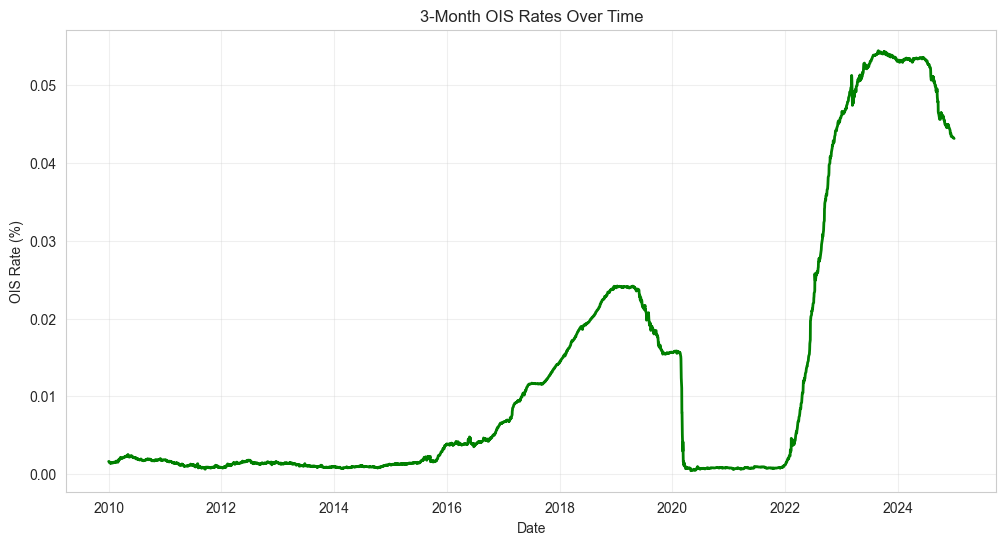

[SPX] Building daily dividend table
Primary input file not found, switching to cached data
[SPX] daily dividends final shape: (3913, 2)
[SPX] Sample daily dividends:
        Date  Daily_Div
0 2010-01-01   0.000000
1 2010-01-04   0.058362
2 2010-01-05   0.001744
3 2010-01-06   0.497980
4 2010-01-07   0.061819
5 2010-01-08   0.000000
6 2010-01-11   0.000000
7 2010-01-12   0.000000
8 2010-01-13   0.113508
9 2010-01-14   0.021957

Intermediate calculation with dividend sums (sample rows):


,Date,Term1_TTM,Term2_TTM,Term1_Futures_Price,Term2_Futures_Price,OIS,Div_Sum1,Div_Sum2
0,2010-01-04,74.0,165.0,1128.75,1124.00,0.00162,4.840390,10.382986
1,2010-01-05,73.0,164.0,1132.25,1127.50,0.00155,4.838646,10.381242
2,2010-01-06,72.0,163.0,1133.00,1128.00,0.00146,4.340666,9.883262
3,2010-01-07,71.0,162.0,1137.50,1132.50,0.00145,4.278847,9.821443
4,2010-01-08,70.0,161.0,1141.50,1136.75,0.00143,4.278847,9.821443



Effect of compounding on dividends (sample rows):


,Date,Div_Sum1,Div_Sum1_Comp,Div_Sum2,Div_Sum2_Comp
0,2010-01-04,4.840390,4.841196,10.382986,10.386841
1,2010-01-05,4.838646,4.839406,10.381242,10.384907
2,2010-01-06,4.340666,4.341300,9.883262,9.886529
3,2010-01-07,4.278847,4.279459,9.821443,9.824647
4,2010-01-08,4.278847,4.279442,9.821443,9.824584



Forward rate calculations (sample rows):


,Date,implied_forward_raw,cal_SPX_rf,ois_fwd_raw,ois_fwd_SPX,spread_SPX
0,2010-01-04,0.000702,0.277667,0.000409,0.161946,0.115721
1,2010-01-05,0.000700,0.276762,0.000392,0.154951,0.121811
2,2010-01-06,0.000479,0.189648,0.000369,0.145957,0.043691
3,2010-01-07,0.000477,0.188897,0.000366,0.144959,0.043939
4,2010-01-08,0.000694,0.274539,0.000361,0.142960,0.131579


Barndorff-Nielsen filter: flagged 47 outliers in spread_SPX


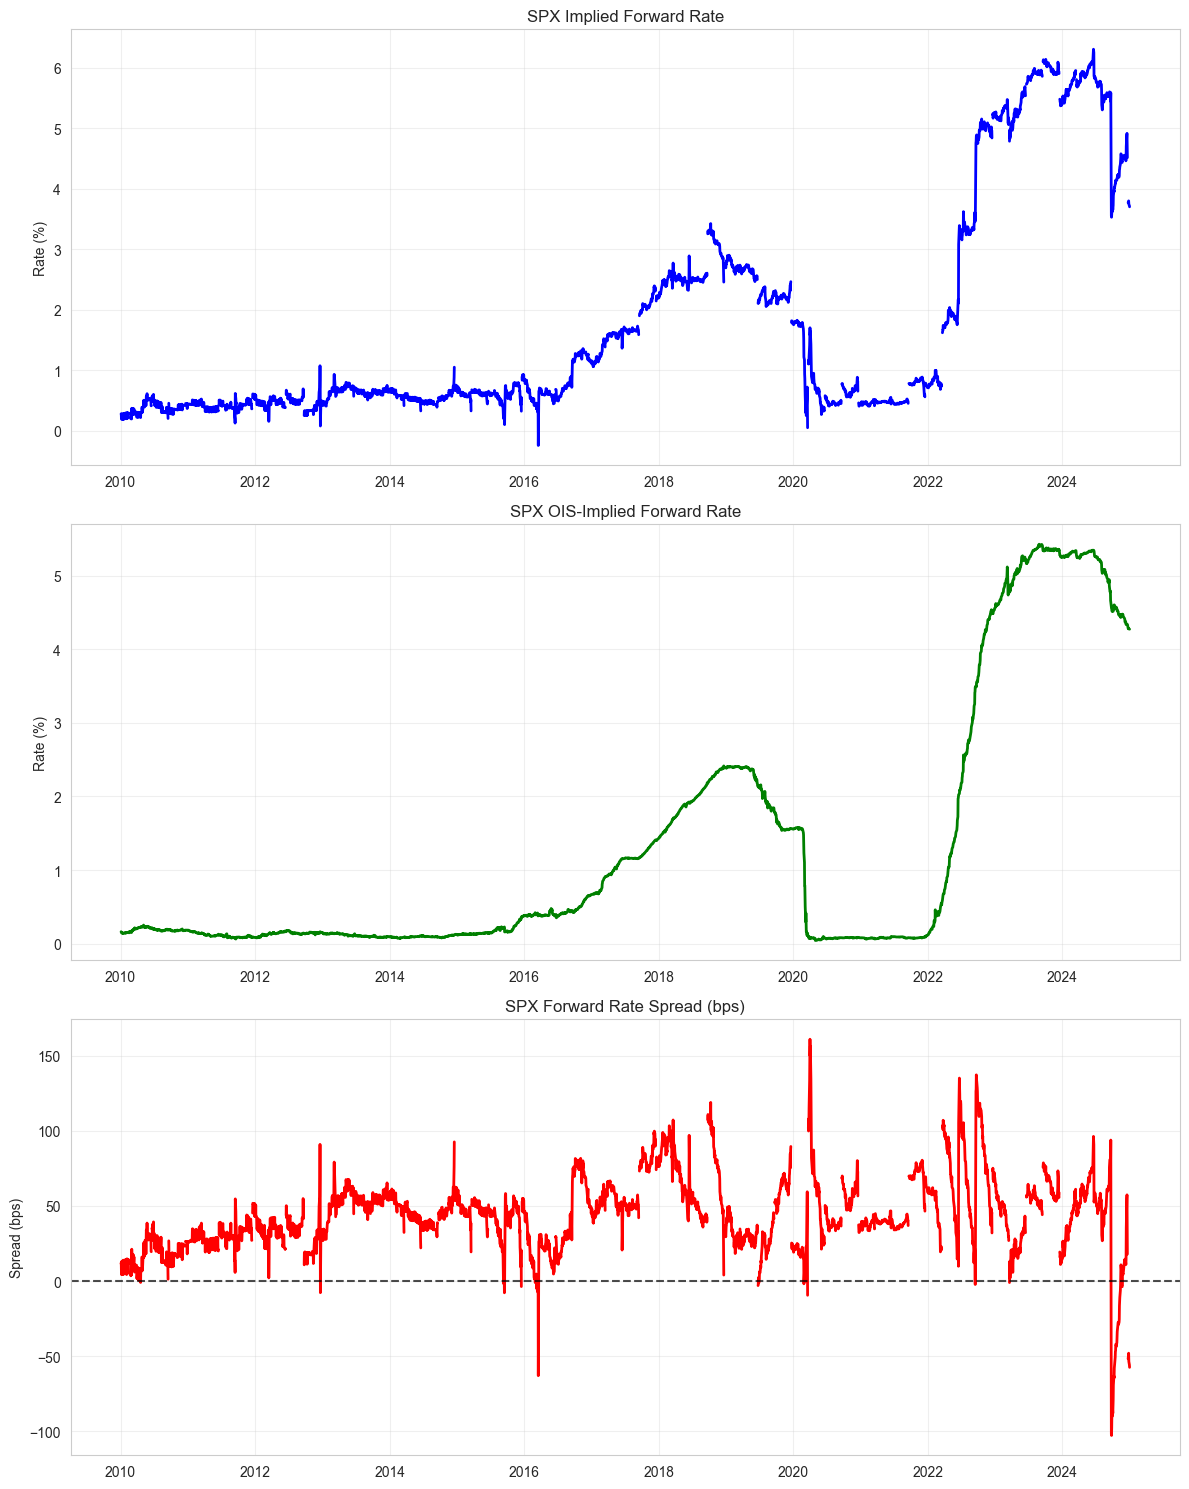


Term structure visualization for date: 2017-06-30 00:00:00


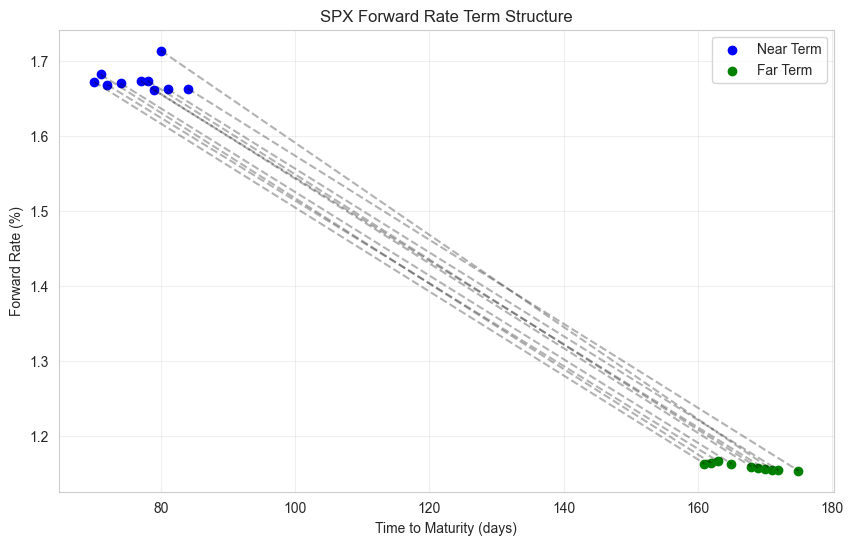

In [9]:
def explore_forward_rate_calculation(index_code="SPX"):
    """
    Explore the steps of the forward rate calculation visually
    """
    print(f"=== Exploring Forward Rate Calculation for {index_code} ===")
    
    # Load necessary data
    fut_file = Path(PROCESSED_DIR) / f"{index_code}_Calendar_spread.csv"
    ois_file = Path(PROCESSED_DIR) / "cleaned_ois_rates.csv"
    
    # Check if files exist
    if not fut_file.exists() or not ois_file.exists():
        print("Required data files not found. Cannot proceed with exploration.")
        return None
    
    # Load calendar spreads
    fut_df = pd.read_csv(fut_file)
    fut_df["Date"] = pd.to_datetime(fut_df["Date"], errors="coerce")
    fut_df.dropna(subset=["Date"], inplace=True)
    fut_df["Term1_SettlementDate"] = pd.to_datetime(fut_df["Term1_SettlementDate"], errors="coerce")
    fut_df["Term2_SettlementDate"] = pd.to_datetime(fut_df["Term2_SettlementDate"], errors="coerce")
    fut_df.sort_values("Date", inplace=True)
    
    # Display calendar spread data
    print("\nFutures Calendar Spread data (first 5 rows):")
    display(fut_df.head())
    
    # Load OIS rates
    ois_df = pd.read_csv(ois_file)
    if "Date" not in ois_df.columns:
        ois_df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    ois_df["Date"] = pd.to_datetime(ois_df["Date"], errors="coerce")
    ois_df.sort_values("Date", inplace=True)
    
    # Display OIS rates
    print("\nOIS rates data (first 5 rows):")
    display(ois_df.head())
    
    # Chart the OIS rates
    plt.figure(figsize=(12, 6))
    plt.plot(ois_df["Date"], ois_df["OIS_3M"], 'g-', linewidth=2)
    plt.title("3-Month OIS Rates Over Time")
    plt.xlabel("Date")
    plt.ylabel("OIS Rate (%)")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Merge futures and OIS data
    merged_df = pd.merge_asof(
        fut_df.sort_values("Date"),
        ois_df,
        on="Date",
        direction="backward"
    )
    
    if "OIS_3M" in merged_df.columns:
        merged_df.rename(columns={"OIS_3M": "OIS"}, inplace=True)
    
    # Load dividends
    div_df = build_daily_dividends(index_code)
    div_df["CumDiv"] = div_df["Daily_Div"].cumsum()
    
    # Merge with current date cumulative dividends
    merged_df = pd.merge_asof(
        merged_df.sort_values("Date"),
        div_df[["Date", "CumDiv"]].sort_values("Date"),
        on="Date",
        direction="backward"
    )
    merged_df.rename(columns={"CumDiv": "CumDiv_current"}, inplace=True)
    
    # Merge with Term1 and Term2 settlement date cumulative dividends
    t1_df = div_df.rename(columns={"Date": "Term1_SettlementDate", "CumDiv": "CumDiv_Term1"})
    merged_df = pd.merge_asof(
        merged_df.sort_values("Term1_SettlementDate"),
        t1_df.sort_values("Term1_SettlementDate"),
        on="Term1_SettlementDate",
        direction="backward"
    )
    
    t2_df = div_df.rename(columns={"Date": "Term2_SettlementDate", "CumDiv": "CumDiv_Term2"})
    merged_df = pd.merge_asof(
        merged_df.sort_values("Term2_SettlementDate"),
        t2_df.sort_values("Term2_SettlementDate"),
        on="Term2_SettlementDate",
        direction="backward"
    )
    
    # Calculate dividend sums
    merged_df["Div_Sum1"] = merged_df["CumDiv_Term1"] - merged_df["CumDiv_current"]
    merged_df["Div_Sum2"] = merged_df["CumDiv_Term2"] - merged_df["CumDiv_current"]
    
    # Display intermediate calculation
    print("\nIntermediate calculation with dividend sums (sample rows):")
    display(merged_df[["Date", "Term1_TTM", "Term2_TTM", "Term1_Futures_Price", 
                      "Term2_Futures_Price", "OIS", "Div_Sum1", "Div_Sum2"]].head())
    
    # Remove rows with missing TTM or price data
    merged_df.dropna(subset=["Term1_TTM", "Term2_TTM", "Term1_Futures_Price", "Term2_Futures_Price"], inplace=True)
    
    # Step-by-step calculation visualization
    
    # 1. Compounding dividends
    merged_df["Div_Sum1_Comp"] = merged_df["Div_Sum1"] * (
        ((merged_df["Term1_TTM"] / 2.0) / 360.0) * merged_df["OIS"] + 1.0
    )
    merged_df["Div_Sum2_Comp"] = merged_df["Div_Sum2"] * (
        ((merged_df["Term2_TTM"] / 2.0) / 360.0) * merged_df["OIS"] + 1.0
    )
    
    # Show effect of compounding
    print("\nEffect of compounding on dividends (sample rows):")
    display(merged_df[["Date", "Div_Sum1", "Div_Sum1_Comp", "Div_Sum2", "Div_Sum2_Comp"]].head())
    
    # 2. Implied forward rate calculation
    merged_df["implied_forward_raw"] = (
        (merged_df["Term2_Futures_Price"] + merged_df["Div_Sum2_Comp"]) /
        (merged_df["Term1_Futures_Price"] + merged_df["Div_Sum1_Comp"])
        - 1.0
    )
    
    dt = merged_df["Term2_TTM"] - merged_df["Term1_TTM"]
    merged_df[f"cal_{index_code}_rf"] = np.where(
        dt > 0,
        100.0 * merged_df["implied_forward_raw"] * (360.0 / dt),
        np.nan
    )
    
    # 3. OIS-implied forward rate
    merged_df["ois_fwd_raw"] = (
        (1.0 + merged_df["OIS"] * merged_df["Term2_TTM"] / 360.0) /
        (1.0 + merged_df["OIS"] * merged_df["Term1_TTM"] / 360.0)
        - 1.0
    )
    merged_df[f"ois_fwd_{index_code}"] = np.where(
        dt > 0,
        merged_df["ois_fwd_raw"] * (360.0 / dt) * 100.0,
        np.nan
    )
    
    # 4. Spread calculation
    spread_col = f"spread_{index_code}"
    merged_df[spread_col] = merged_df[f"cal_{index_code}_rf"] - merged_df[f"ois_fwd_{index_code}"]
    
    # Show forward rate calculations
    print("\nForward rate calculations (sample rows):")
    display(merged_df[[
        "Date", 
        "implied_forward_raw", 
        f"cal_{index_code}_rf", 
        "ois_fwd_raw", 
        f"ois_fwd_{index_code}", 
        spread_col
    ]].head())
    
    # Apply Barndorff-Nielsen filter
    filtered_df = barndorff_nielsen_filter(merged_df, spread_col, date_col="Date", window=45, threshold=10)
    
    # Set outliers to NaN
    out_mask = filtered_df[f"{spread_col}_filtered"].isna()
    filtered_df.loc[out_mask, f"cal_{index_code}_rf"] = np.nan
    filtered_df.loc[out_mask, spread_col] = np.nan
    
    # Multiply spread by 100 for bps
    filtered_df[spread_col] = filtered_df[spread_col] * 100.0
    
    # Set index to Date for time series plots
    filtered_df.set_index("Date", inplace=True)
    
    # Visualize the forward rates and spread
    plt.figure(figsize=(12, 15))
    
    # Plot 1: Implied Forward Rate
    plt.subplot(3, 1, 1)
    plt.plot(filtered_df.index, filtered_df[f"cal_{index_code}_rf"], 'b-', linewidth=2)
    plt.title(f"{index_code} Implied Forward Rate")
    plt.ylabel("Rate (%)")
    plt.grid(True, alpha=0.3)
    
    # Plot 2: OIS Forward Rate
    plt.subplot(3, 1, 2)
    plt.plot(filtered_df.index, filtered_df[f"ois_fwd_{index_code}"], 'g-', linewidth=2)
    plt.title(f"{index_code} OIS-Implied Forward Rate")
    plt.ylabel("Rate (%)")
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Spread
    plt.subplot(3, 1, 3)
    plt.plot(filtered_df.index, filtered_df[spread_col], 'r-', linewidth=2)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.7)
    plt.title(f"{index_code} Forward Rate Spread (bps)")
    plt.ylabel("Spread (bps)")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize the term structure
    plt.figure(figsize=(10, 6))
    
    # Get a sample date for demonstration
    sample_date = filtered_df.index[len(filtered_df) // 2]  # Middle of the dataset
    print(f"\nTerm structure visualization for date: {sample_date}")
    
    # Filter for a reasonable window around the sample date
    date_window = 5  # Days
    sample_window = filtered_df.index.get_indexer([sample_date], method='nearest')[0]
    sample_window_start = max(0, sample_window - date_window)
    sample_window_end = min(len(filtered_df), sample_window + date_window)
    
    sample_data = filtered_df.iloc[sample_window_start:sample_window_end]
    
    # Plot term structure
    for date in sample_data.index:
        row = filtered_df.loc[date]
        plt.scatter(row["Term1_TTM"], row[f"cal_{index_code}_rf"], color='blue', label='Near Term' if date == sample_data.index[0] else "")
        plt.scatter(row["Term2_TTM"], row[f"ois_fwd_{index_code}"], color='green', label='Far Term' if date == sample_data.index[0] else "")
        
        # Connect the points with a line
        plt.plot([row["Term1_TTM"], row["Term2_TTM"]], 
                 [row[f"cal_{index_code}_rf"], row[f"ois_fwd_{index_code}"]], 
                 'k--', alpha=0.3)
    
    plt.title(f"{index_code} Forward Rate Term Structure")
    plt.xlabel("Time to Maturity (days)")
    plt.ylabel("Forward Rate (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return filtered_df

# Run the exploration
forward_rate_df = explore_forward_rate_calculation("SPX")

## Understanding the Forward Rate Calculation Process

When computing **equity spot-futures arbitrage** for an index \( S_t \) paying dividends from \( t \) to \( t + \tau \), we combine:

- **Futures Prices** (from the nearest and next-nearest futures contracts)
- **OIS Rates** (as a proxy for the risk-free rate)
- **Realized Dividends** (as a simple forecast of expected dividends)

These are merged into a single DataFrame, from which we derive an **implied forward rate** \( \cal{rf} \) and compare it with the **OIS-implied forward rate** to compute an **arbitrage spread**.

### 1. Data Preparation & Merging
1. **Calendar Spread Data**  
   Provides columns for:
   - `Term1_Futures_Price` and `Term2_Futures_Price` (prices for near-term and deferred futures)
   - `Term1_SettlementDate` and `Term2_SettlementDate`
   - `Term1_TTM` and `Term2_TTM` (time-to-maturity in days)
2. **OIS Rates**  
   Contains daily 3-month OIS rates, merged into the calendar spread data via an as-of backward merge on `Date`.
3. **Dividends**  
   - We accumulate daily dividends into a `CumDiv` series.
   - Merged at both the **current date** and each **futures settlement date** to approximate how much dividend would be paid between now and each maturity.

### 2. Dividend Sums
Let:
- $ \text{CumDiv}_\text{current} $ = cumulative dividend at the current date
- $ \text{CumDiv}_{\text{Term1}} $ = cumulative dividend at the Term1 settlement date
- $ \text{CumDiv}_{\text{Term2}} $ = cumulative dividend at the Term2 settlement date

Then:

$$
\text{Div\_Sum1} = \text{CumDiv}_{\text{Term1}} - \text{CumDiv}_\text{current},
\quad
\text{Div\_Sum2} = \text{CumDiv}_{\text{Term2}} - \text{CumDiv}_\text{current}.
$$

### 3. Dividend Compounding
We apply a **half-interval compounding** for each dividend sum:

$$
\text{Div\_Sum1\_Comp} \;=\; \text{Div\_Sum1} \times
\Bigl(\bigl(\tfrac{\text{Term1\_TTM}}{2 \times 360}\bigr) \times \text{OIS} \;+\; 1.0\Bigr).
$$

$$
\text{Div\_Sum2\_Comp} \;=\; \text{Div\_Sum2} \times
\Bigl(\bigl(\tfrac{\text{Term2\_TTM}}{2 \times 360}\bigr) \times \text{OIS} \;+\; 1.0\Bigr).
$$

### 4. Implied Forward Rate
From Hazelkorn et al. (2021), the **raw** implied forward rate (over \(\tau_1\) to \(\tau_2\)) is:

$$
\text{implied\_forward\_raw} \;=\;
\frac{\text{Term2\_Futures\_Price} + \text{Div\_Sum2\_Comp}}{\text{Term1\_Futures\_Price} + \text{Div\_Sum1\_Comp}}
\;-\; 1.
$$

We **annualize** this raw rate by multiplying according to the difference in time-to-maturity (\(\text{Term2\_TTM} - \text{Term1\_TTM}\)):

$$
\text{cal\_rf}_{index} \;=\;
100 \times \text{implied\_forward\_raw} \;\times\;
\frac{360}{\text{Term2\_TTM} - \text{Term1\_TTM}}.
$$

### 5. OIS-Implied Forward Rate
Similarly, we estimate how **OIS** would imply a forward rate between \(\tau_1\) and \(\tau_2\):

$$
\text{ois\_fwd\_raw} \;=\;
\frac{1 + \text{OIS} \times \tfrac{\text{Term2\_TTM}}{360}}
     {1 + \text{OIS} \times \tfrac{\text{Term1\_TTM}}{360}}
\;-\; 1.
$$

We annualize it in the same manner:

$$
\text{ois\_fwd}_{index} \;=\;
\text{ois\_fwd\_raw} \;\times\;
\frac{360}{\text{Term2\_TTM} - \text{Term1\_TTM}} \;\times\; 100.
$$

### 6. Spread Calculation
We define the **arbitrage spread** in **basis points** (bps) as:

$$
\text{spread}_{index} \;=\;
\bigl(\text{cal\_rf}_{index} - \text{ois\_fwd}_{index}\bigr) \times 100.
$$

A **positive** spread indicates the **futures-implied forward rate** is **higher** than the OIS-implied rate.

### 7. Outlier Filtering
We apply a **Barndorff–Nielsen filter** on `spread_{index}` to flag outliers based on rolling median absolute deviation. These flagged values are set to `NaN` to remove spurious spikes or data errors. 

---

**Interpretation**  
- **Spot-Futures Parity** would suggest the forward rate extracted from futures = OIS rate, making the spread near zero.  
- A **non-zero** spread implies potential **frictions**, **funding constraints**, or **margin requirements** that might limit arbitrage.  

1. **Futures + Dividends** yield an **equity-implied forward rate** over \(\tau_1 \to \tau_2\).  
2. **OIS** gives an alternative “risk-free” benchmark.  
3. Comparing them highlights possible **arbitrage** or **funding market** dislocations.


=== Exploring Cross-Index Forward Rate Analysis ===

Processing SPX...
[SPX] Starting forward rate computation
[SPX] Loaded futures shape: (3781, 14)
[SPX] Dropped 0 rows lacking a valid Date in futures.
[SPX] as-of merged OIS: from 3781 -> 3781 rows (should be same).
[SPX] Building daily dividend table
Primary input file not found, switching to cached data
[SPX] daily dividends final shape: (3913, 2)
[SPX] Sample daily dividends:
        Date  Daily_Div
0 2010-01-01   0.000000
1 2010-01-04   0.058362
2 2010-01-05   0.001744
3 2010-01-06   0.497980
4 2010-01-07   0.061819
5 2010-01-08   0.000000
6 2010-01-11   0.000000
7 2010-01-12   0.000000
8 2010-01-13   0.113508
9 2010-01-14   0.021957
[SPX] as-of merged CumDiv at current date: from 3781 -> 3781 rows.
[SPX] Sample merged rows with cumulative div:
        Date  Term1_Futures_Price  Term1_Volume  Term1_OpenInterest  \
0 2010-01-04              1128.75     1282633.0           2440458.0   
1 2010-01-05              1132.25     1368386.

Barndorff-Nielsen filter: flagged 47 outliers in spread_SPX
[SPX] Setting 47 outliers to NaN for cal_SPX_rf & spread_SPX
[SPX] Final forward rates shape: (3781, 29)
[SPX] Sample final rows:
            cal_SPX_rf  ois_fwd_SPX  spread_SPX
Date                                           
2024-12-24    3.778583     4.287412  -50.882869
2024-12-26    3.796641     4.277498  -48.085749
2024-12-27    3.741256     4.277624  -53.636841
2024-12-30    3.717731     4.275913  -55.818186
2024-12-31    3.698950     4.274017  -57.506667

Processing NDX...
[NDX] Starting forward rate computation
[NDX] Loaded futures shape: (3781, 14)
[NDX] Dropped 0 rows lacking a valid Date in futures.
[NDX] as-of merged OIS: from 3781 -> 3781 rows (should be same).
[NDX] Building daily dividend table
Primary input file not found, switching to cached data
[NDX] daily dividends final shape: (3913, 2)
[NDX] Sample daily dividends:
        Date  Daily_Div
0 2010-01-01   0.000000
1 2010-01-04   0.148515
2 2010-01-05   0.00

Barndorff-Nielsen filter: flagged 48 outliers in spread_NDX
[NDX] Setting 48 outliers to NaN for cal_NDX_rf & spread_NDX
[NDX] Final forward rates shape: (3781, 29)
[NDX] Sample final rows:
            cal_NDX_rf  ois_fwd_NDX  spread_NDX
Date                                           
2024-12-24    4.341428     4.287412    5.401572
2024-12-26    4.426357     4.277498   14.885916
2024-12-27    4.384662     4.277624   10.703781
2024-12-30    4.322400     4.275913    4.648708
2024-12-31    4.323851     4.274017    4.983391

Processing INDU...
[INDU] Starting forward rate computation
[INDU] Loaded futures shape: (3780, 14)
[INDU] Dropped 0 rows lacking a valid Date in futures.
[INDU] as-of merged OIS: from 3780 -> 3780 rows (should be same).
[INDU] Building daily dividend table
Primary input file not found, switching to cached data
[INDU] daily dividends final shape: (3913, 2)
[INDU] Sample daily dividends:
        Date  Daily_Div
0 2010-01-01   0.000000
1 2010-01-04   0.377875
2 2010-01-0

Barndorff-Nielsen filter: flagged 43 outliers in spread_INDU
[INDU] Setting 43 outliers to NaN for cal_INDU_rf & spread_INDU
[INDU] Final forward rates shape: (3780, 29)
[INDU] Sample final rows:
            cal_INDU_rf  ois_fwd_INDU  spread_INDU
Date                                              
2024-12-24     3.525951      4.287412   -76.146147
2024-12-26     3.485142      4.277498   -79.235563
2024-12-27     3.459165      4.277624   -81.845864
2024-12-30     3.446690      4.275913   -82.922307
2024-12-31     3.377212      4.274017   -89.680496

Combined spreads data (first rows):


,spread_SPX,spread_NDX,spread_INDU
2010-01-04,11.572066,22.661276,25.302054
2010-01-05,12.181110,18.151200,26.010192
2010-01-06,4.369103,24.426083,23.178006
2010-01-07,4.393865,14.026219,23.177080
2010-01-08,13.157910,8.811714,23.300181


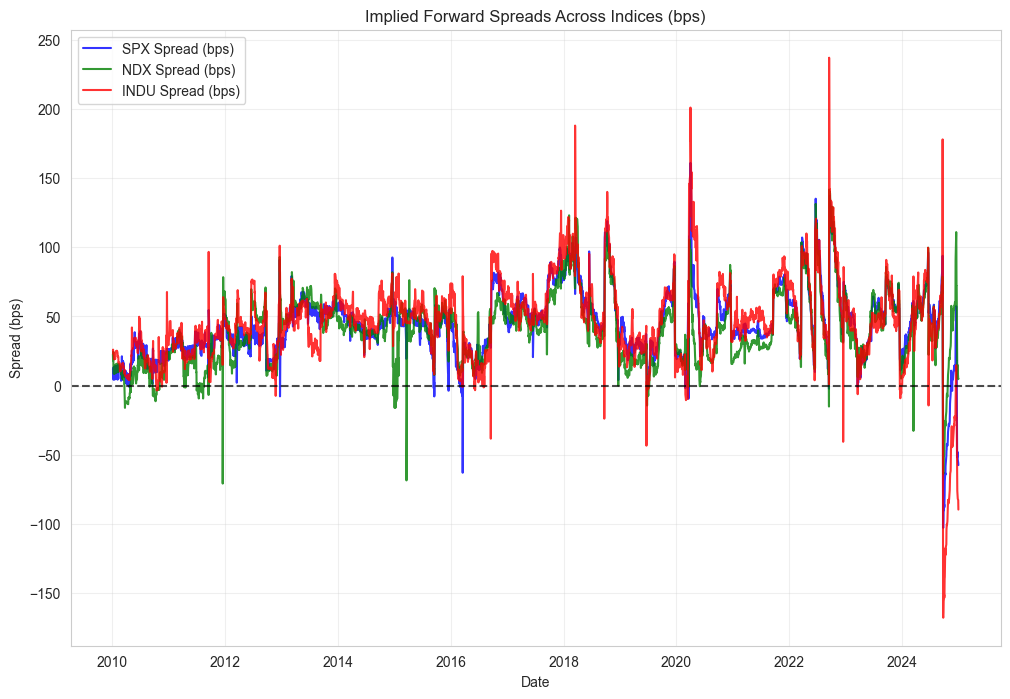


Correlation matrix of spreads:


,spread_SPX,spread_NDX,spread_INDU
spread_SPX,1.000000,0.842434,0.894422
spread_NDX,0.842434,1.000000,0.745491
spread_INDU,0.894422,0.745491,1.000000


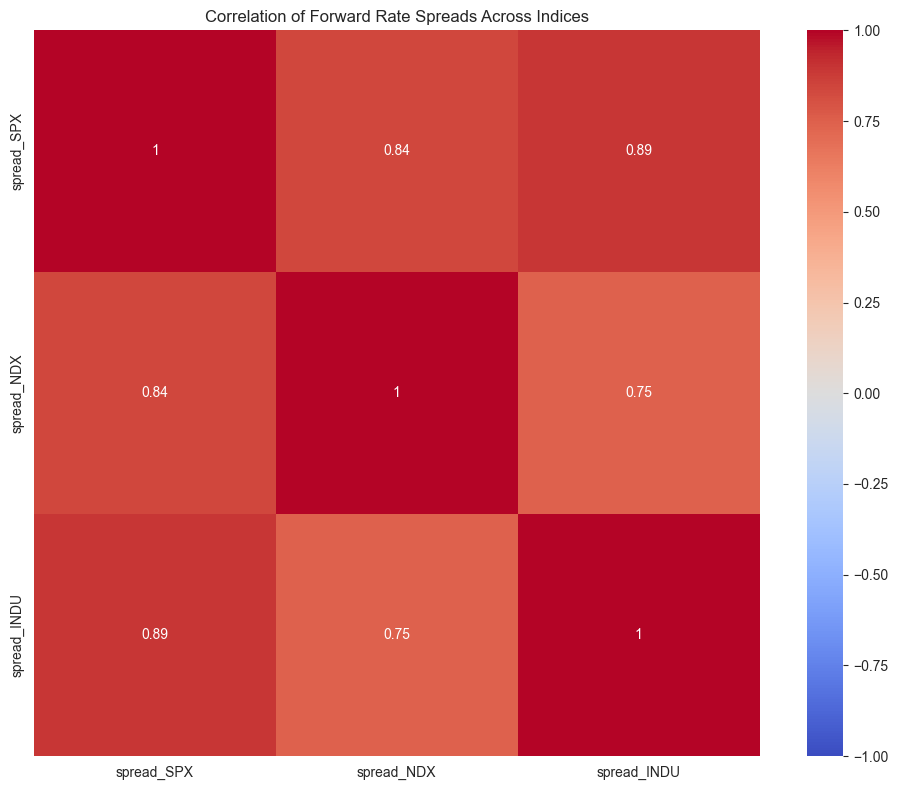

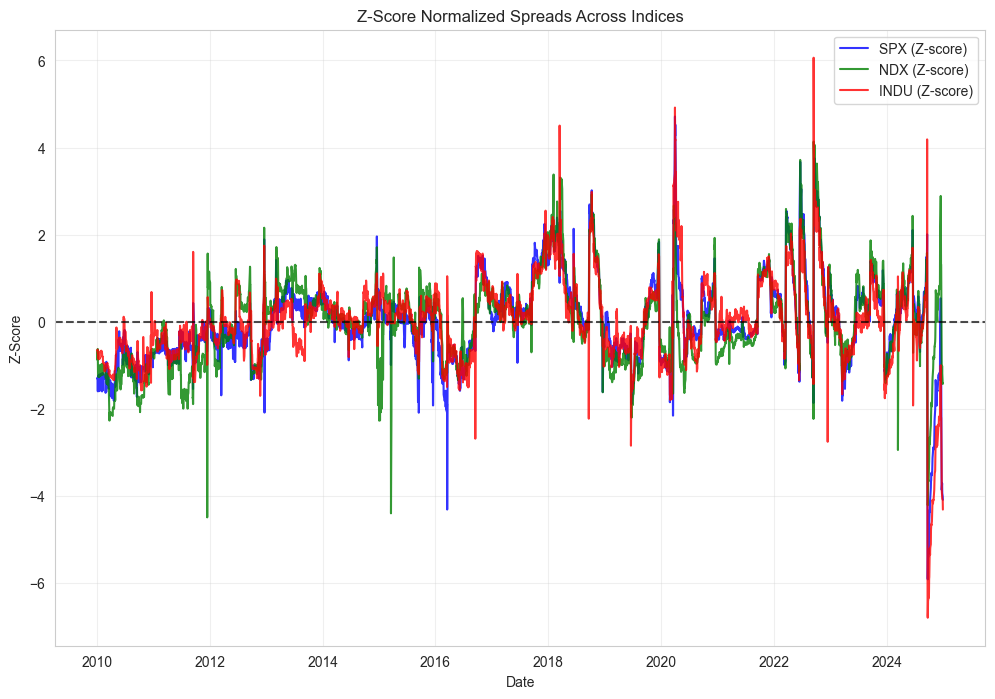

In [10]:
# 4. Comparing Forward Rates Across Indices

def explore_cross_index_comparison():
    """
    Compare forward rates and spreads across different indices to identify patterns and relationships
    """
    print("=== Exploring Cross-Index Forward Rate Analysis ===")
    
    # Process data for all indices
    results = {}
    for idx in INDEX_CODES:
        print(f"\nProcessing {idx}...")
        
        fut_file = Path(PROCESSED_DIR) / f"{idx}_Calendar_spread.csv"
        if not fut_file.exists():
            print(f"  Missing futures file for {idx}, skipping.")
            continue
        
        # Run the forward rate calculation
        df_res = process_index_forward_rates(idx)
        if df_res is not None and not df_res.empty:
            results[idx] = df_res
    
    if not results:
        print("No valid results to compare. Ending exploration.")
        return None
    
    # Create a unified DataFrame with spreads from all indices
    # First, find the union of all dates
    all_dates = set()
    for idx, df in results.items():
        all_dates.update(df.index.tolist())
    
    # Sort dates
    date_index = pd.to_datetime(sorted(all_dates))
    
    # Create a DataFrame with all spreads
    spreads_df = pd.DataFrame(index=date_index)
    
    for idx, df in results.items():
        spread_col = f"spread_{idx}"
        # Forward fill to handle missing dates
        spreads_df[spread_col] = df[spread_col].reindex(date_index).ffill()
    
    # Show the head of the combined spreads
    print("\nCombined spreads data (first rows):")
    display(spreads_df.head())
    
    # Visualize combined spreads
    plt.figure(figsize=(12, 8))
    
    colors = {"SPX": "blue", "NDX": "green", "INDU": "red"}
    for idx in results.keys():
        spread_col = f"spread_{idx}"
        plt.plot(
            spreads_df.index, 
            spreads_df[spread_col], 
            color=colors.get(idx, "black"),
            alpha=0.8,
            label=f"{idx} Spread (bps)"
        )
    
    plt.axhline(0, color="k", linestyle="--", alpha=0.7)
    plt.title("Implied Forward Spreads Across Indices (bps)")
    plt.xlabel("Date")
    plt.ylabel("Spread (bps)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate correlations between spreads
    if len(results) > 1:
        corr_matrix = spreads_df.corr()
        print("\nCorrelation matrix of spreads:")
        display(corr_matrix)
        
        # Visualize correlations
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
        plt.title("Correlation of Forward Rate Spreads Across Indices")
        plt.tight_layout()
        plt.show()
    
    # Z-score normalized spreads for comparison
    if not spreads_df.empty:
        # Calculate z-scores for each spread
        z_scores_df = pd.DataFrame(index=spreads_df.index)
        
        for col in spreads_df.columns:
            z_scores_df[col] = (spreads_df[col] - spreads_df[col].mean()) / spreads_df[col].std()
        
        # Visualize normalized spreads
        plt.figure(figsize=(12, 8))
        
        for idx in results.keys():
            spread_col = f"spread_{idx}"
            plt.plot(
                z_scores_df.index, 
                z_scores_df[spread_col], 
                color=colors.get(idx, "black"),
                alpha=0.8,
                label=f"{idx} (Z-score)"
            )
        
        plt.axhline(0, color="k", linestyle="--", alpha=0.7)
        plt.title("Z-Score Normalized Spreads Across Indices")
        plt.xlabel("Date")
        plt.ylabel("Z-Score")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    
    return spreads_df
cross_index_df = explore_cross_index_comparison()

=== Exploring Economic Significance of Forward Rate Spreads ===
[SPX] Starting forward rate computation
[SPX] Loaded futures shape: (3781, 14)
[SPX] Dropped 0 rows lacking a valid Date in futures.
[SPX] as-of merged OIS: from 3781 -> 3781 rows (should be same).
[SPX] Building daily dividend table
Primary input file not found, switching to cached data
[SPX] daily dividends final shape: (3913, 2)
[SPX] Sample daily dividends:
        Date  Daily_Div
0 2010-01-01   0.000000
1 2010-01-04   0.058362
2 2010-01-05   0.001744
3 2010-01-06   0.497980
4 2010-01-07   0.061819
5 2010-01-08   0.000000
6 2010-01-11   0.000000
7 2010-01-12   0.000000
8 2010-01-13   0.113508
9 2010-01-14   0.021957
[SPX] as-of merged CumDiv at current date: from 3781 -> 3781 rows.
[SPX] Sample merged rows with cumulative div:
        Date  Term1_Futures_Price  Term1_Volume  Term1_OpenInterest  \
0 2010-01-04              1128.75     1282633.0           2440458.0   
1 2010-01-05              1132.25     1368386.0      

Barndorff-Nielsen filter: flagged 47 outliers in spread_SPX
[SPX] Setting 47 outliers to NaN for cal_SPX_rf & spread_SPX
[SPX] Final forward rates shape: (3781, 29)
[SPX] Sample final rows:
            cal_SPX_rf  ois_fwd_SPX  spread_SPX
Date                                           
2024-12-24    3.778583     4.287412  -50.882869
2024-12-26    3.796641     4.277498  -48.085749
2024-12-27    3.741256     4.277624  -53.636841
2024-12-30    3.717731     4.275913  -55.818186
2024-12-31    3.698950     4.274017  -57.506667

Spread direction summary:
  Positive spread: 96.9% of the time
  Negative spread: 1.8% of the time
  Zero or missing: 1.2% of the time


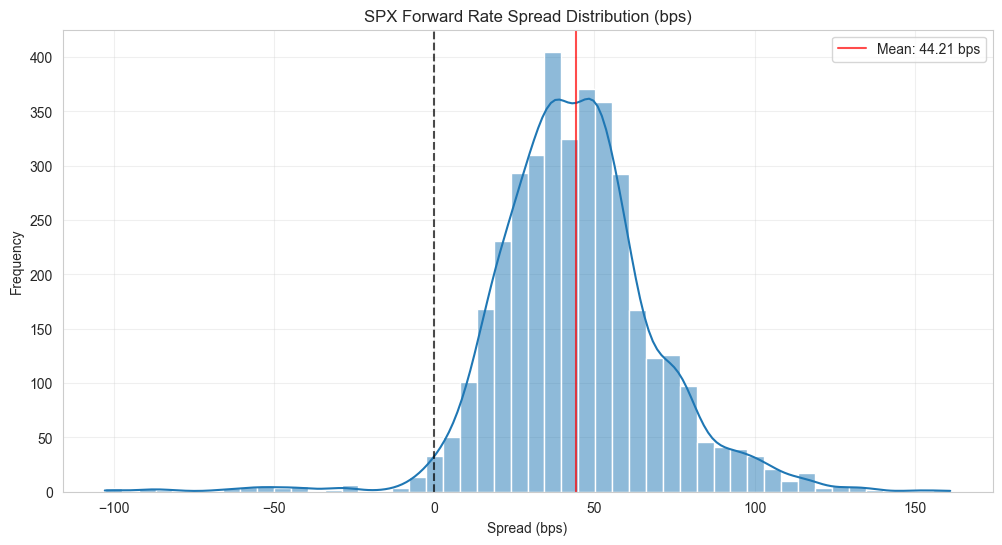

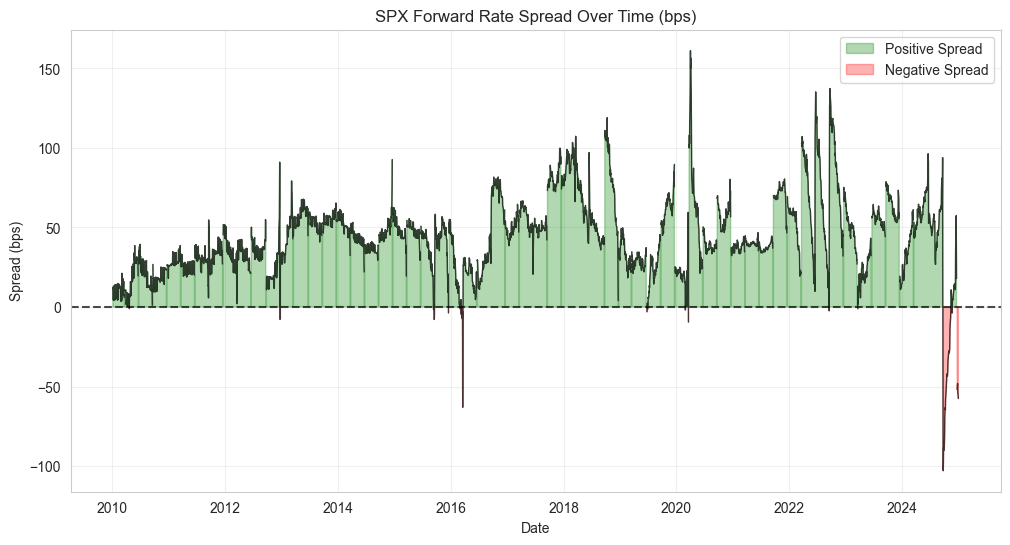


Regime persistence:
  Positive spread regimes: 59
  Average positive regime duration: 62.1 days
  Longest positive regime: 191 days
  Negative spread regimes: 17
  Average negative regime duration: 4.1 days
  Longest negative regime: 37 days


C:\Users\Andik\AppData\Local\Temp\ipykernel_8\1733434661.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True,


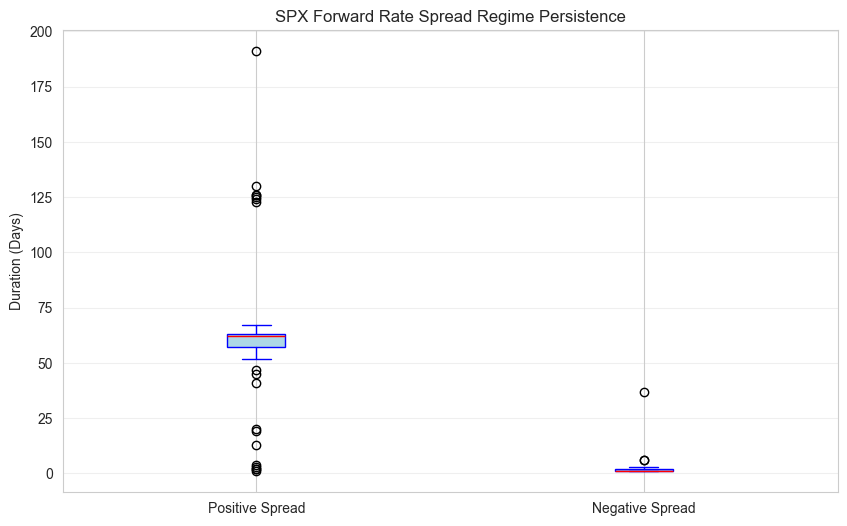

In [11]:
# 5. Exploring the Economic Significance of Forward Rate Spreads

def explore_economic_significance():
    """
    Analyze the economic significance of forward rate spreads
    """
    print("=== Exploring Economic Significance of Forward Rate Spreads ===")
    
    # Process data for SPX (as an example)
    index_code = "SPX"
    fut_file = Path(PROCESSED_DIR) / f"{index_code}_Calendar_spread.csv"
    
    if not fut_file.exists():
        print(f"Missing futures file for {index_code}. Cannot proceed with exploration.")
        return None
    
    # Run the forward rate calculation
    df_res = process_index_forward_rates(index_code)
    
    if df_res is None or df_res.empty:
        print("No valid results. Ending exploration.")
        return None
    
    # Set the spread column
    spread_col = f"spread_{index_code}"
    
    
    # Calculate the percentage of time the spread is positive vs negative
    positive_spread = (df_res[spread_col] > 0).mean() * 100
    negative_spread = (df_res[spread_col] < 0).mean() * 100
    
    print(f"\nSpread direction summary:")
    print(f"  Positive spread: {positive_spread:.1f}% of the time")
    print(f"  Negative spread: {negative_spread:.1f}% of the time")
    print(f"  Zero or missing: {100 - positive_spread - negative_spread:.1f}% of the time")
    
    # Visualize the distribution of spreads
    plt.figure(figsize=(12, 6))
    
    sns.histplot(df_res[spread_col].dropna(), bins=50, kde=True)
    plt.axvline(0, color='k', linestyle='--', alpha=0.7)
    plt.axvline(df_res[spread_col].mean(), color='r', linestyle='-', alpha=0.7, 
                label=f'Mean: {df_res[spread_col].mean():.2f} bps')
    
    plt.title(f"{index_code} Forward Rate Spread Distribution (bps)")
    plt.xlabel("Spread (bps)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Create a time plot with positive/negative highlighting
    plt.figure(figsize=(12, 6))
    
    # Plot the spread
    plt.plot(df_res.index, df_res[spread_col], 'k-', alpha=0.7, linewidth=1)
    
    # Highlight positive and negative regions
    positive_mask = df_res[spread_col] > 0
    negative_mask = df_res[spread_col] < 0
    
    plt.fill_between(df_res.index, 0, df_res[spread_col], where=positive_mask, 
                     color='green', alpha=0.3, label='Positive Spread')
    plt.fill_between(df_res.index, 0, df_res[spread_col], where=negative_mask, 
                     color='red', alpha=0.3, label='Negative Spread')
    
    plt.axhline(0, color='k', linestyle='--', alpha=0.7)
    plt.title(f"{index_code} Forward Rate Spread Over Time (bps)")
    plt.xlabel("Date")
    plt.ylabel("Spread (bps)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate persistence - how long spreads stay positive or negative
    df_res['spread_sign'] = np.sign(df_res[spread_col])
    df_res['regime_change'] = df_res['spread_sign'].diff().ne(0).astype(int)
    df_res['regime_id'] = df_res['regime_change'].cumsum()
    
    # Get regime lengths
    regime_lengths = df_res.groupby('regime_id').size()
    
    # Separate positive and negative regimes
    regime_signs = df_res.groupby('regime_id')['spread_sign'].first()
    
    positive_lengths = regime_lengths[regime_signs > 0]
    negative_lengths = regime_lengths[regime_signs < 0]
    
    print("\nRegime persistence:")
    if not positive_lengths.empty:
        print(f"  Positive spread regimes: {len(positive_lengths)}")
        print(f"  Average positive regime duration: {positive_lengths.mean():.1f} days")
        print(f"  Longest positive regime: {positive_lengths.max()} days")
    
    if not negative_lengths.empty:
        print(f"  Negative spread regimes: {len(negative_lengths)}")
        print(f"  Average negative regime duration: {negative_lengths.mean():.1f} days")
        print(f"  Longest negative regime: {negative_lengths.max()} days")
    
    # Visualize regime persistence with a boxplot
    plt.figure(figsize=(10, 6))
    
    data = [positive_lengths, negative_lengths]
    labels = ['Positive Spread', 'Negative Spread']
    
    plt.boxplot(data, labels=labels, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                medianprops=dict(color='red'))
    
    plt.title(f"{index_code} Forward Rate Spread Regime Persistence")
    plt.ylabel("Duration (Days)")
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()
    
    
    return df_res

# Run the exploration
economic_df = explore_economic_significance()

# Theoretical Understanding of Implied Forward Rate Calculation

## 1. Understanding Daily Dividends

The daily dividend processing is a crucial first step in forward rate calculation. It involves:

- **Data Source**: Extracting dividend data from Bloomberg historical data
- **Processing Steps**: Converting dates, handling missing values, and calculating cumulative dividends
- **Key Insight**: Dividends accumulate over time and impact future values of the index
- **Seasonality**: There are often patterns in dividend distributions throughout the year
- **Importance**: Accurate dividend projections are essential for proper forward rate calculation

Understanding how dividends accumulate between the current date and settlement dates is critical. The spread between nearby and farther-term futures contracts must account for these dividend payments.

## 2. Barndorff-Nielsen Outlier Filter

The Barndorff-Nielsen filter identifies and removes statistical outliers in time series data:

- **Core Components**:
  - Rolling median calculation (robust central tendency measure)
  - Absolute deviation from the median
  - Mean absolute deviation (MAD) as a scale measure
  - Standardized deviation (absolute deviation / MAD)
  - Threshold comparison to identify outliers

- **Key Advantages**:
  - Insensitive to extreme values (unlike mean/standard deviation)
  - Adapts to local characteristics of the time series
  - Preserves legitimate signal changes while removing anomalies

- **Application to Forward Rates**:
  - Removes data errors or market dislocations that would distort analysis
  - Helps identify true arbitrage opportunities vs. data anomalies

## 3. Forward Rate Calculation Process

The forward rate calculation is based on the cost-of-carry model with dividends:

- **Step 1: Data Merging**
  - Calendar spread data (near/next futures prices and settlement dates)
  - OIS rates (risk-free benchmark)
  - Daily dividends (accumulation between current and settlement dates)

- **Step 2: Dividend Sum Calculation**
  - Calculate expected dividends between observation date and both settlement dates
  - Apply half-interval compounding using the OIS rate to account for time value

- **Step 3: Implied Forward Rate Calculation**
  - Calculate raw implied forward rate from futures prices and compounded dividends
  - Annualize the rate by dividing by the time difference and multiplying by 360

- **Step 4: OIS-implied Forward Rate**
  - Calculate the theoretical forward rate based solely on OIS rates
  - This represents the risk-free expectation of future rates

- **Step 5: Spread Calculation**
  - The difference between implied and OIS forward rates represents potential arbitrage
  - Expressed in basis points for easier interpretation

The theoretical foundation is that under no-arbitrage conditions, the spread should be zero. Deviations represent market inefficiencies or risk premia.

## 4. Cross-Index Analysis

Comparing forward rate spreads across different indices offers deeper insights:

- **Correlation Analysis**:
  - High correlation suggests common market drivers
  - Low correlation indicates index-specific factors

- **Z-Score Normalization**:
  - Allows comparison of spreads with different volatility characteristics
  - Highlights periods of abnormal behavior across indices

- **Rolling Correlation**:
  - Shows how relationships between indices evolve over time
  - Can identify regime changes in market integration

Differences in spread behavior across indices may reveal:
- Different dividend expectations
- Index-specific liquidity constraints
- Varying market microstructure


## 5. Theoretical Framework

The implied forward rate calculation is grounded in financial theory:

- **Cost-of-Carry Model**:
  - F(t,T) = S(t) × e^((r-d)(T-t))
  - Where F is futures price, S is spot price, r is risk-free rate, d is dividend yield

- **No-Arbitrage Principle**:
  - In perfectly efficient markets with no frictions, the implied forward rate should equal the OIS forward rate
  - Deviations create arbitrage opportunities

- **Yield Curve Theory**:
  - Forward rates contain information about market expectations of future interest rates
  - Term structure shapes influence the relationship between near and far-term rates

- **Funding Liquidity**:
  - Constraints in funding can create persistent deviations from theoretical values
  - The spread can be viewed as a measure of funding conditions

- **Dividend Uncertainty**:
  - Differences between expected and actual dividends affect the spread
  - Market pricing may include a risk premium for dividend uncertainty
